### 方法(制約付きサンプリング)
```
while 調べるべき特徴量がある限り :
    for 調べる特徴量 in 調べる特徴量の数 :
        ある特徴量ベクトルxiと元のy(y^)の内積を求める(t^i)
        for 100程度 :
            y^を、{t0 = t^0かつt1 = t^1...tj = t^j}という条件の元サンプリング（nealを使う）しyを生成する。
            ある特徴量ベクトルxiとyの内積を求める(ti)
        複数のtiを求めることによって得られた分布に対するt^iの位置から、p値を求める。
    p値の一番小さいXs[交絡因子]を知る。
    条件{}にts = t^sを足す（更新する）
    調べる特徴量からXsを除外（更新する）
```
<br/>

#### **交絡因子とexact logistic regression**
交絡因子を除いたあと、p値を求めその値が大きかったとき、交絡因子はデータに対して大きく相関していたということがわかる。

### 条件について
- t0 = t^0 : 1の総和が同じ
- tj = t^j : xの特徴量jつ目とyの内積の値が同じ


### yのサンプリング
- コンパイルを行うまでは`pyqubo`
- SAは`SimulatedAnnealingSampler()`

### 改訂(08/03)
- ori_tiのkeyがなかった場合に1とする必要がない
- sum([j[1] for j in ti_list])は必ず100である

### 改訂（08/04）
- numreads=100を使用

### 改訂（08/06）
- numreadsを100, 500, 1000などとするかlogspaceにするか
- 10回の平均を記録しplot
- t^0をとりあえず出すか

In [19]:
#!pip3 install dwave-neal

In [20]:
import pandas as pd 
import numpy as np
from neal import SimulatedAnnealingSampler
from pyqubo import Array, Constraint, Placeholder, solve_qubo

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

In [22]:
X_mushroom = pd.read_csv("../input/SNP_df1010.csv", sep=',', index_col=0)
y_mushroom = pd.read_csv('../input/y10.csv', sep=',', index_col=0)['y']

num_samples = X_mushroom.shape[0]
num_cols = X_mushroom.shape[1]
columns = list(X_mushroom.columns)

y_sum = sum(y_mushroom)

In [23]:
num_samples
num_cols

10

In [24]:
y_sum

6

#### to_quboでのトライアル（t^0だけ）

In [41]:
#numreadsは作るサンプル数（ダブリはあるはず）
#numreadsは100, 500, 1000とするか、logをとるか(np.logspace)

numreads_10 = np.logspace(1, 4, num=4, base=10, dtype=int)
len(numreads_10) #4
print(numreads_10)

numreads_5 = [ll*100 for ll in range(1, 21) if ll%5==0 or ll==1]
len(numreads_5) #5
print(numreads_5)

[   10   100  1000 10000]
[100, 500, 1000, 1500, 2000]


        A       B       C       D       E       F       G       H       I    J
0  0.1652  0.8790  0.4548  0.4536  0.5515  0.7373  0.7313  0.9949  0.9680  1.0
1  0.1670  0.8774  0.4530  0.4532  0.5459  0.7365  0.7366  0.9942  0.9666  1.0
2  0.1655  0.8820  0.4559  0.4633  0.5433  0.7367  0.7354  0.9954  0.9656  1.0
3  0.1651  0.8790  0.4476  0.4512  0.5386  0.7326  0.7415  0.9944  0.9688  1.0
4  0.1719  0.8820  0.4516  0.4524  0.5434  0.7366  0.7347  0.9950  0.9672  1.0
5  0.1699  0.8790  0.4477  0.4534  0.5518  0.7368  0.7305  0.9961  0.9675  1.0
6  0.1709  0.8815  0.4629  0.4523  0.5567  0.7376  0.7405  0.9959  0.9651  1.0
7  0.1630  0.8798  0.4521  0.4506  0.5459  0.7357  0.7405  0.9958  0.9615  1.0
8  0.1703  0.8855  0.4442  0.4421  0.5560  0.7363  0.7455  0.9949  0.9661  1.0
9  0.1613  0.8840  0.4418  0.4477  0.5441  0.7387  0.7333  0.9949  0.9704  1.0


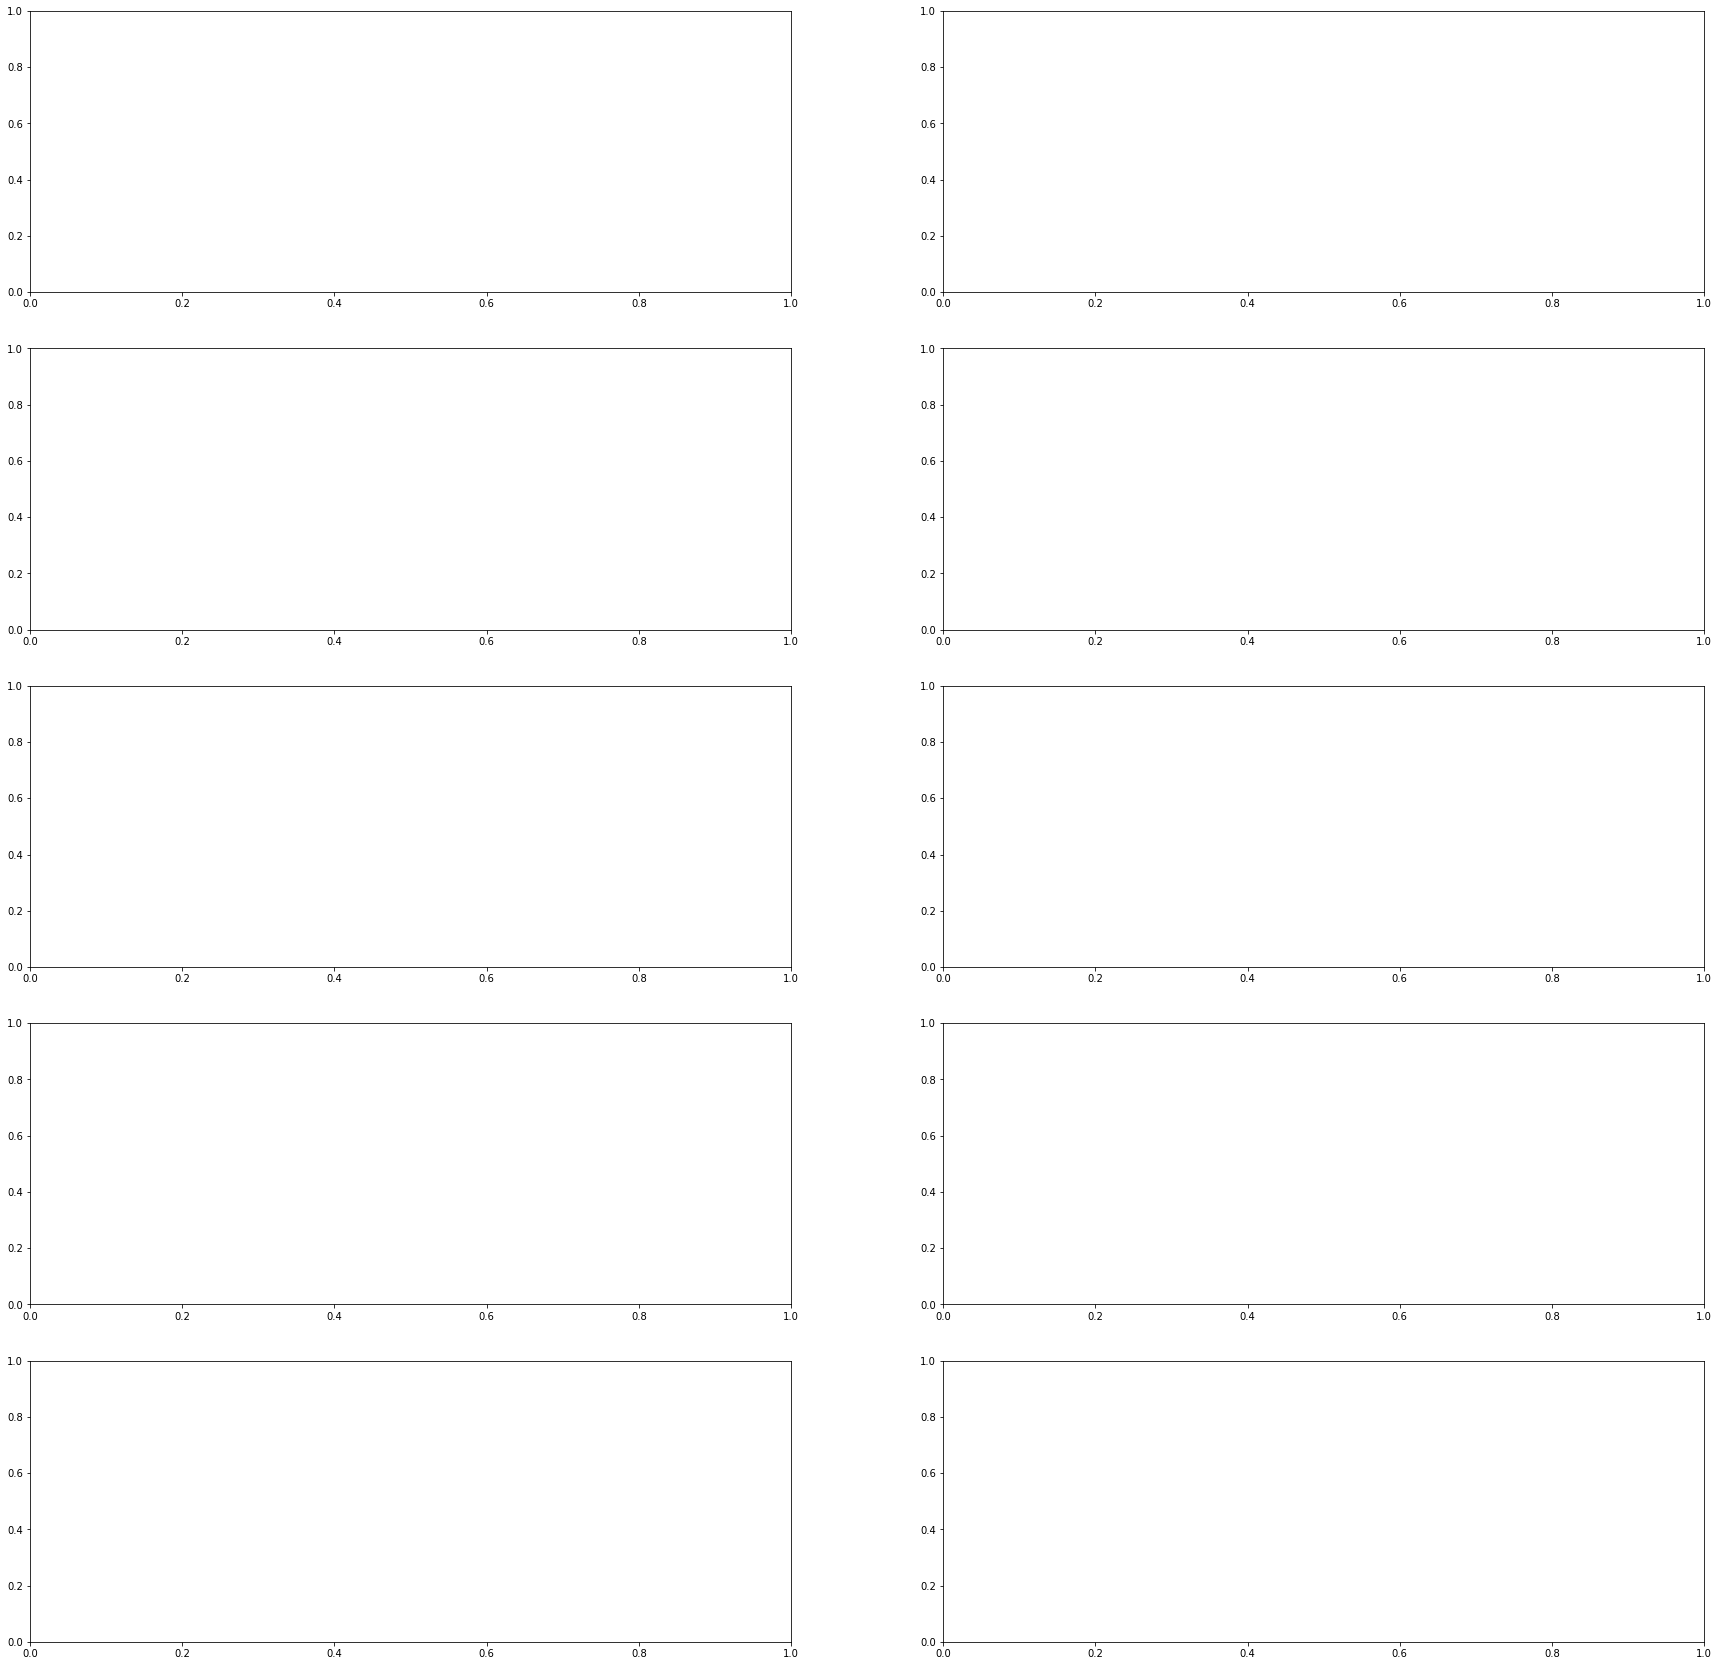

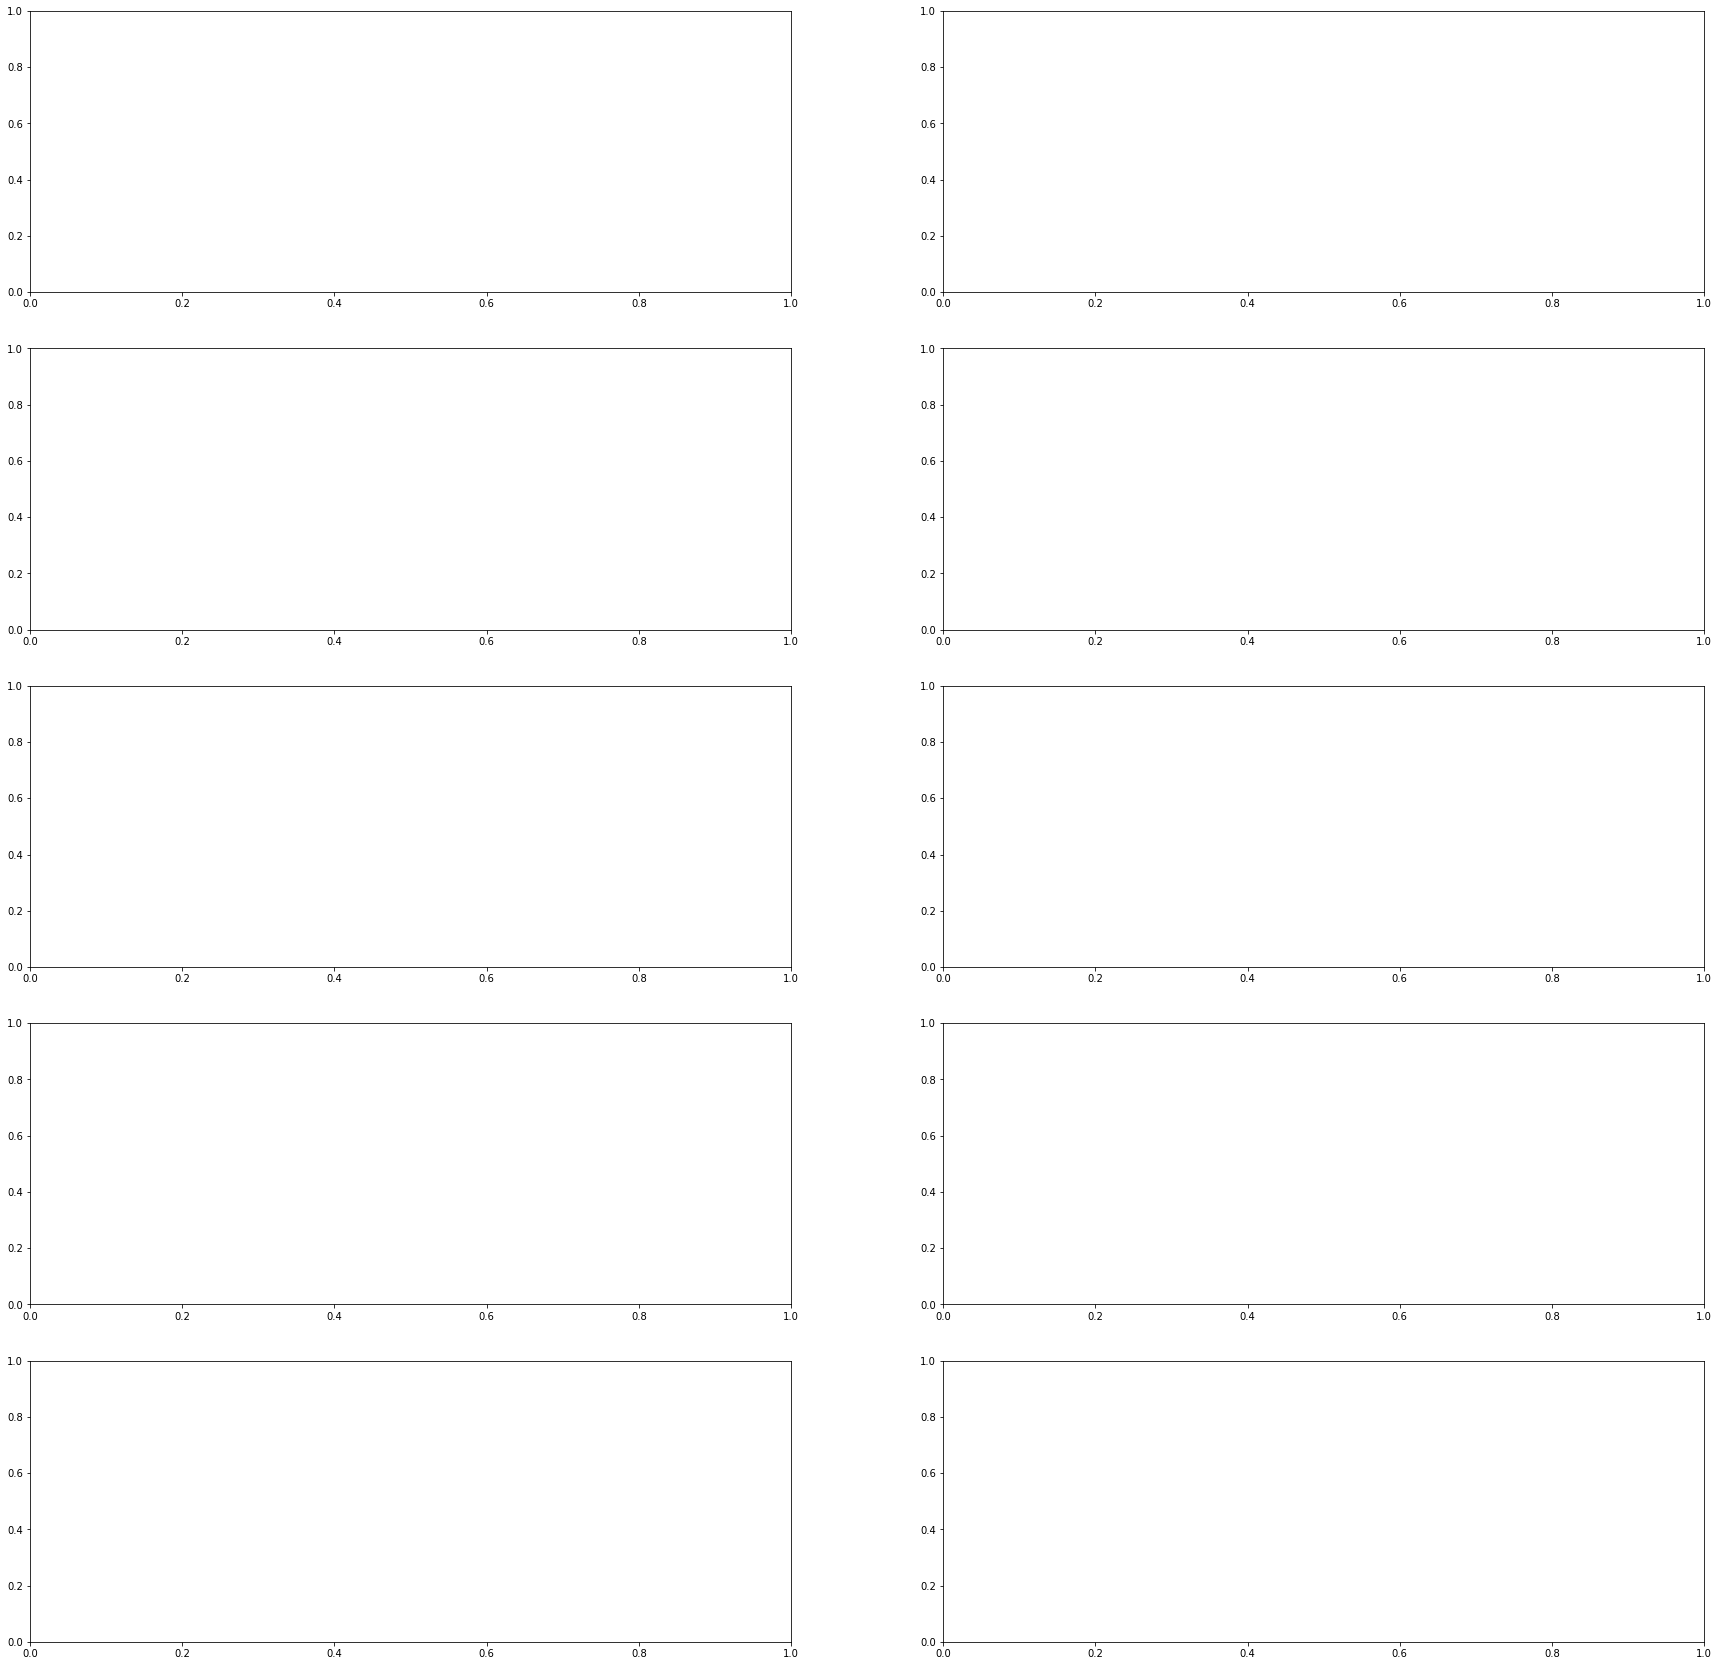

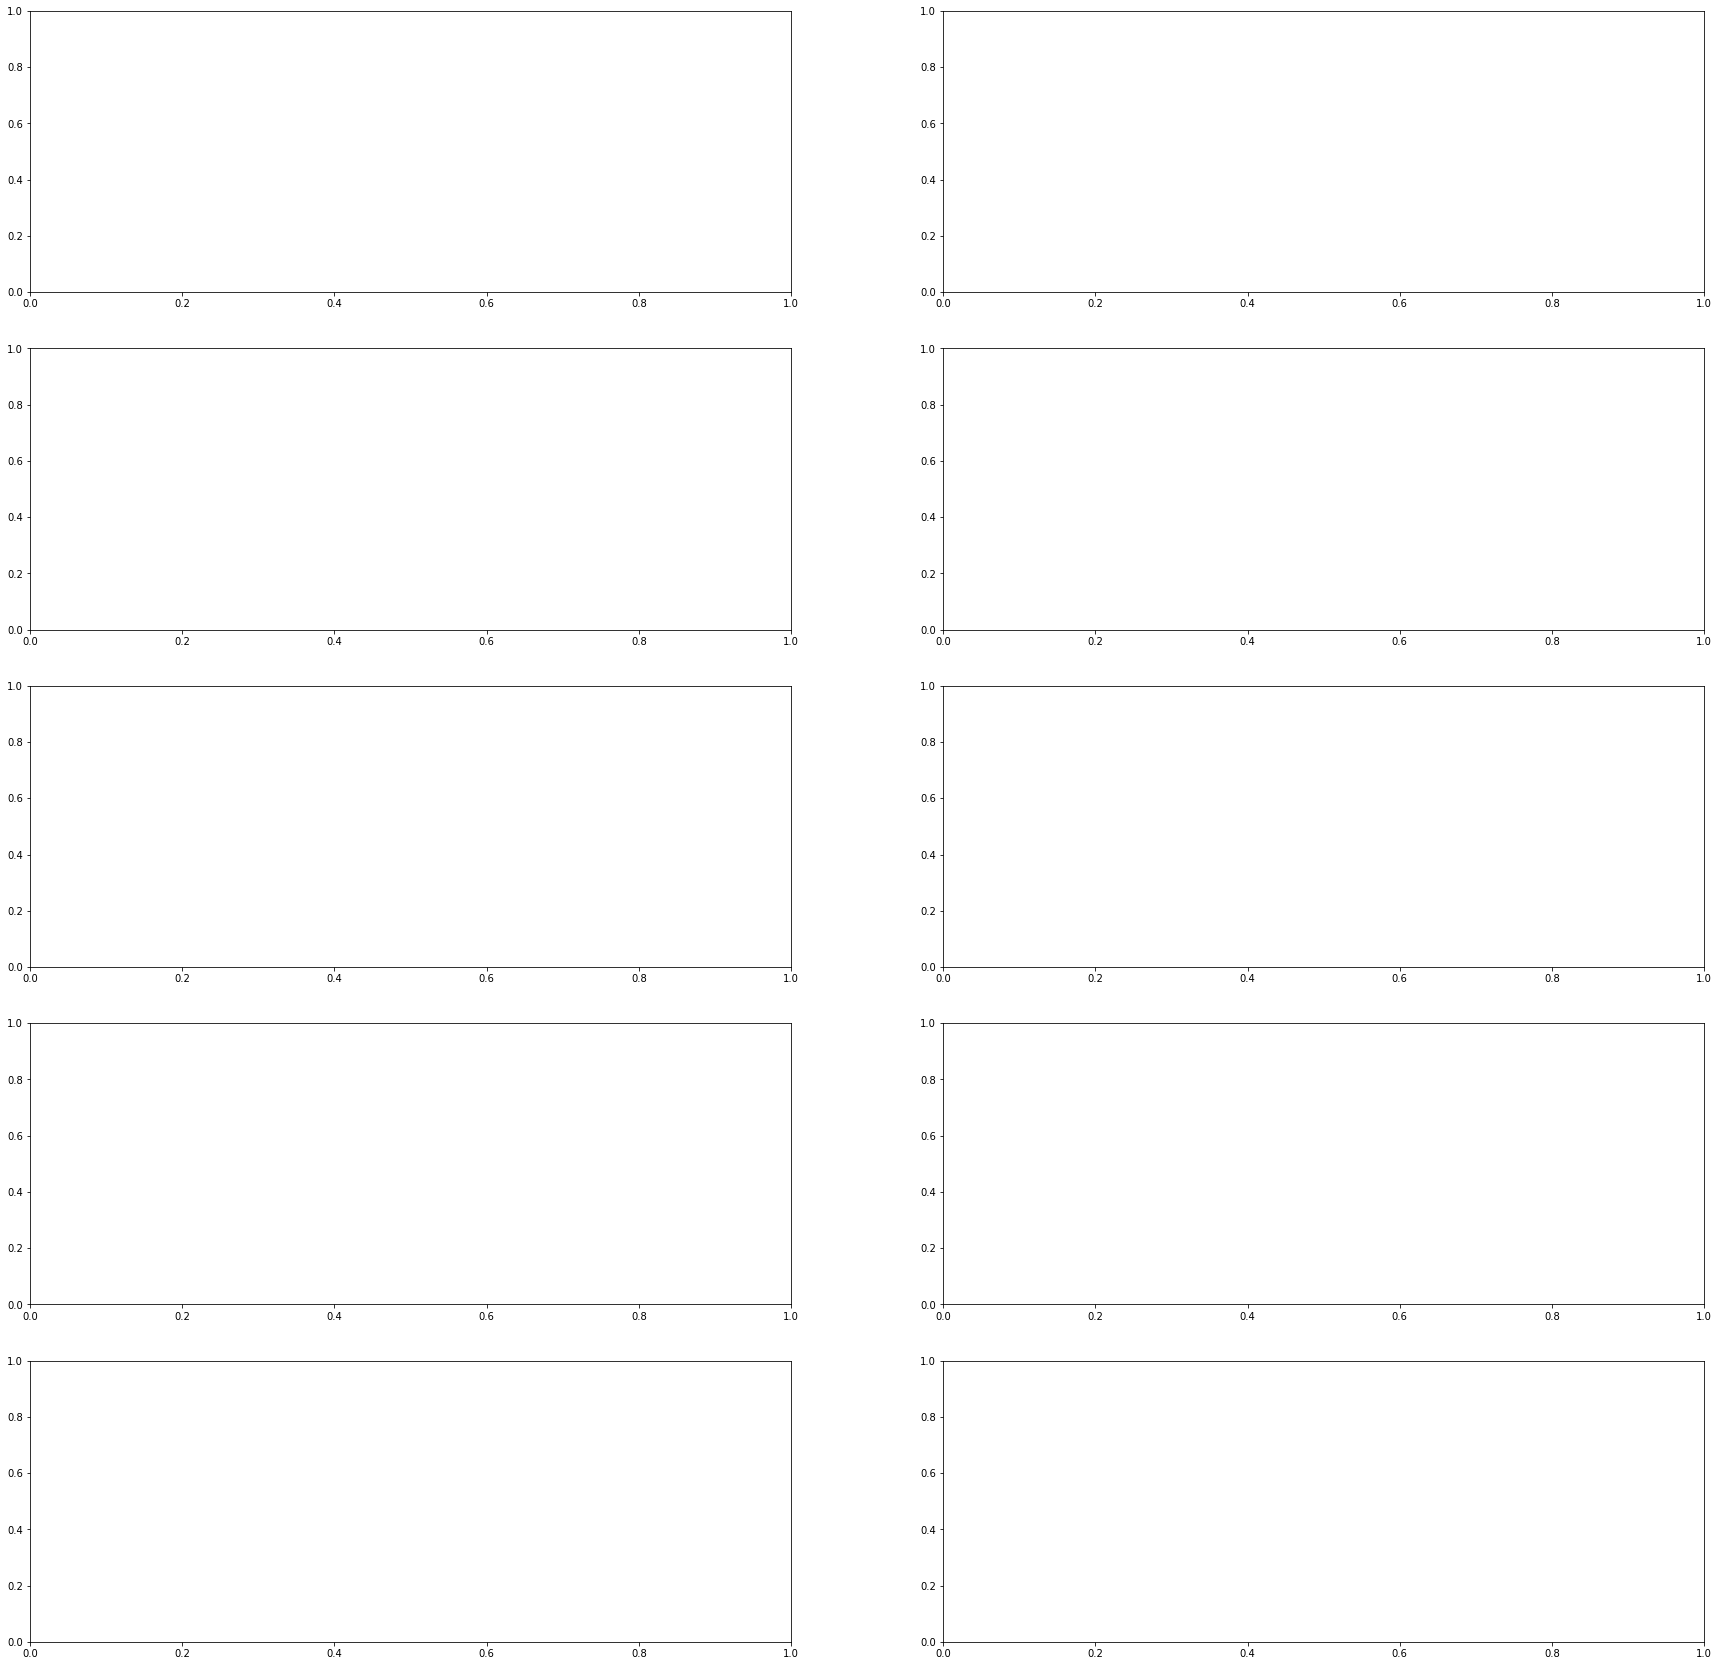

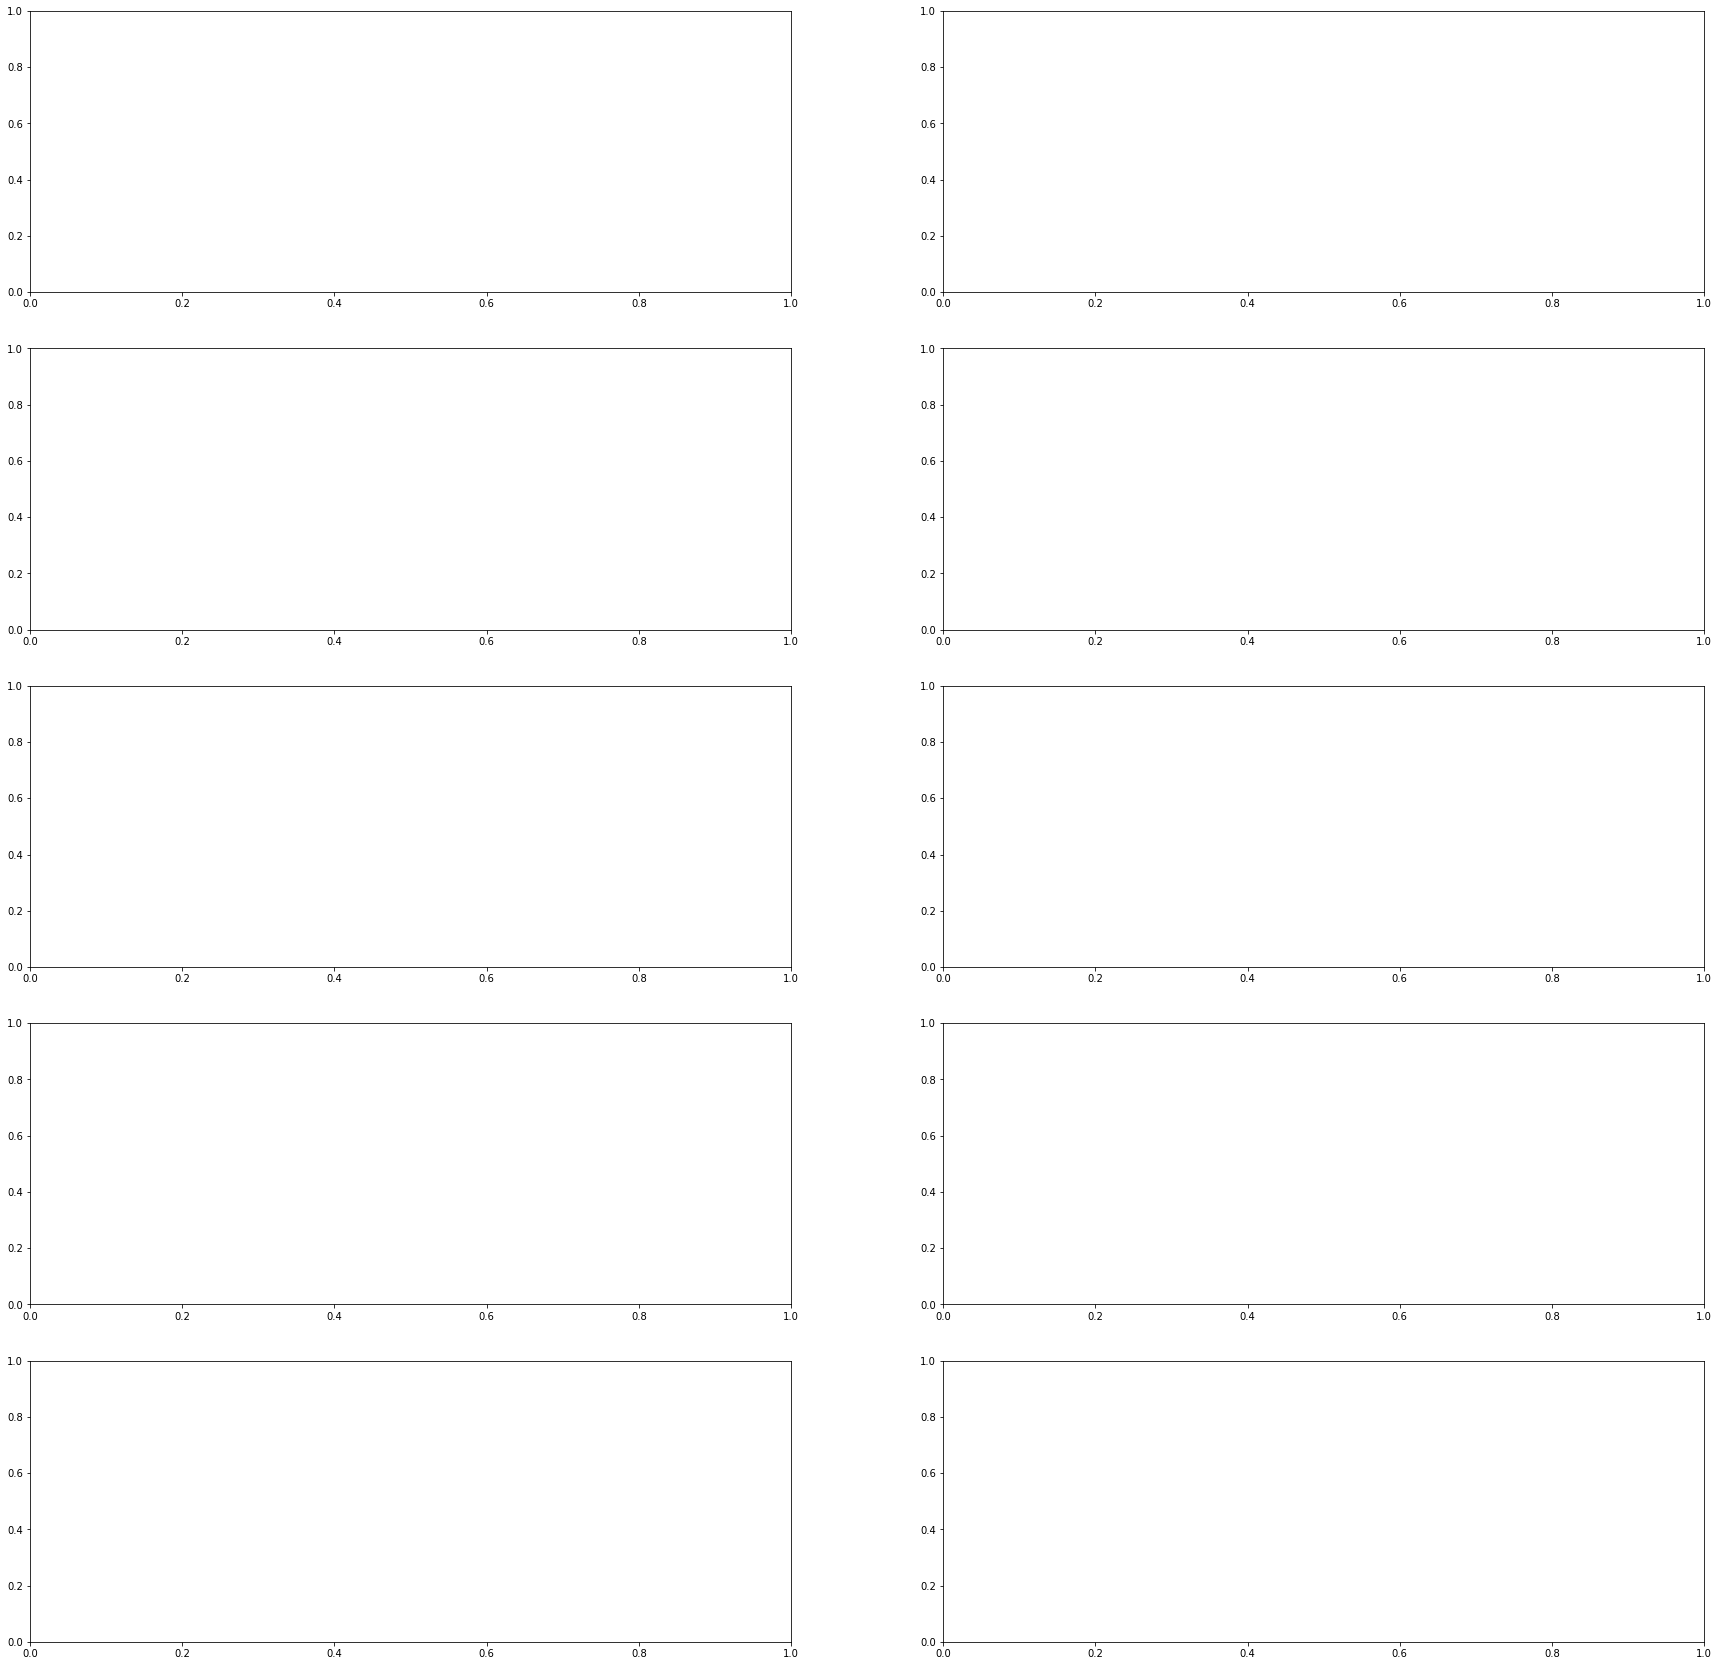

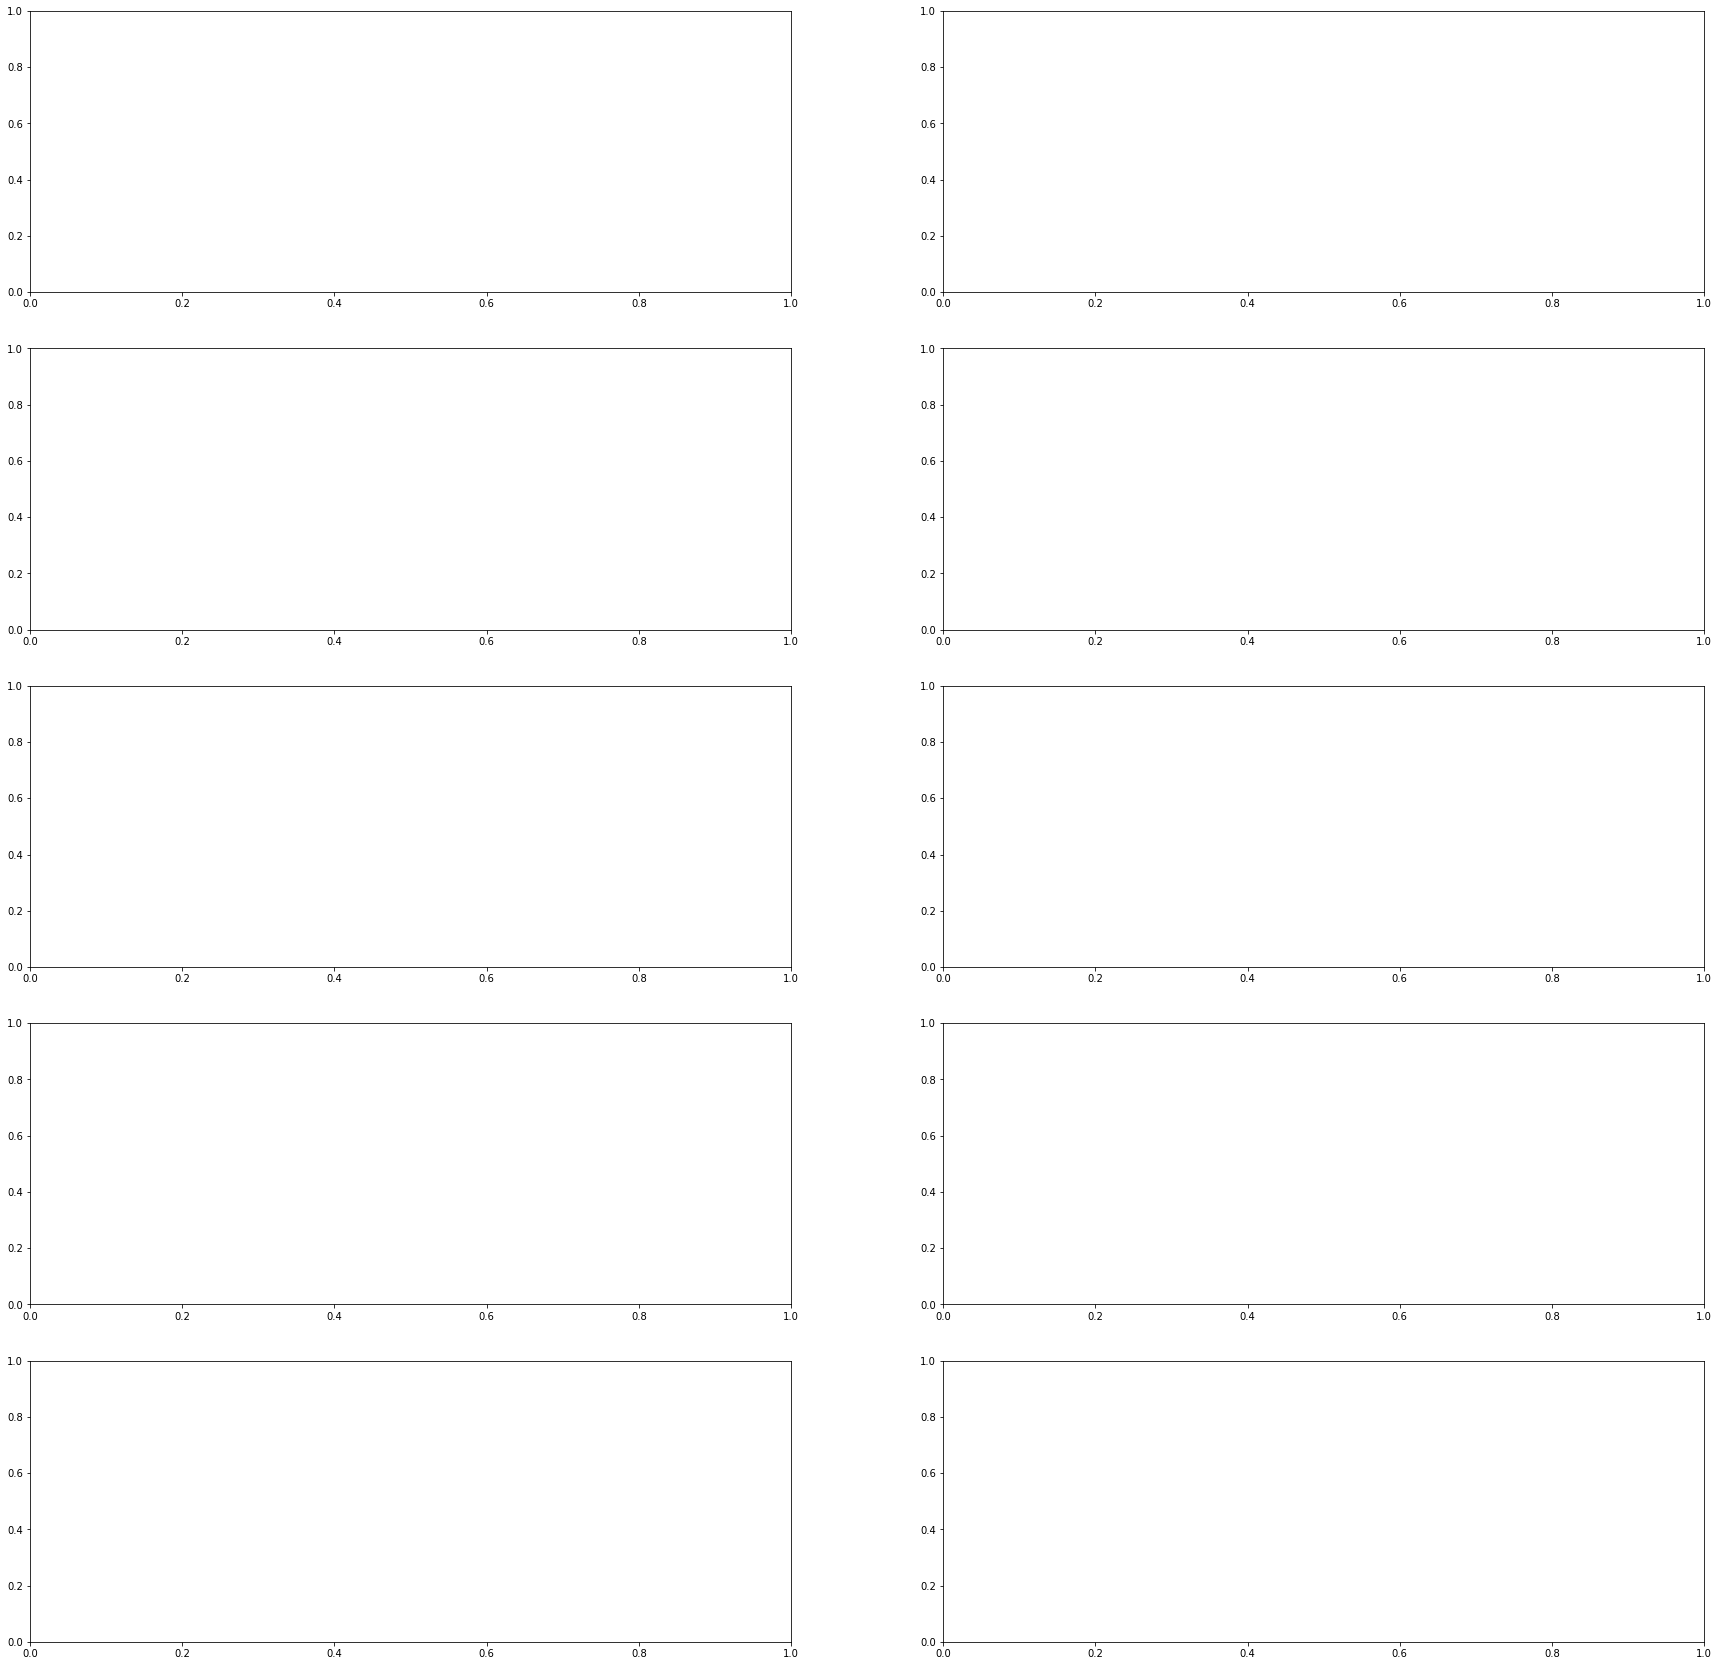

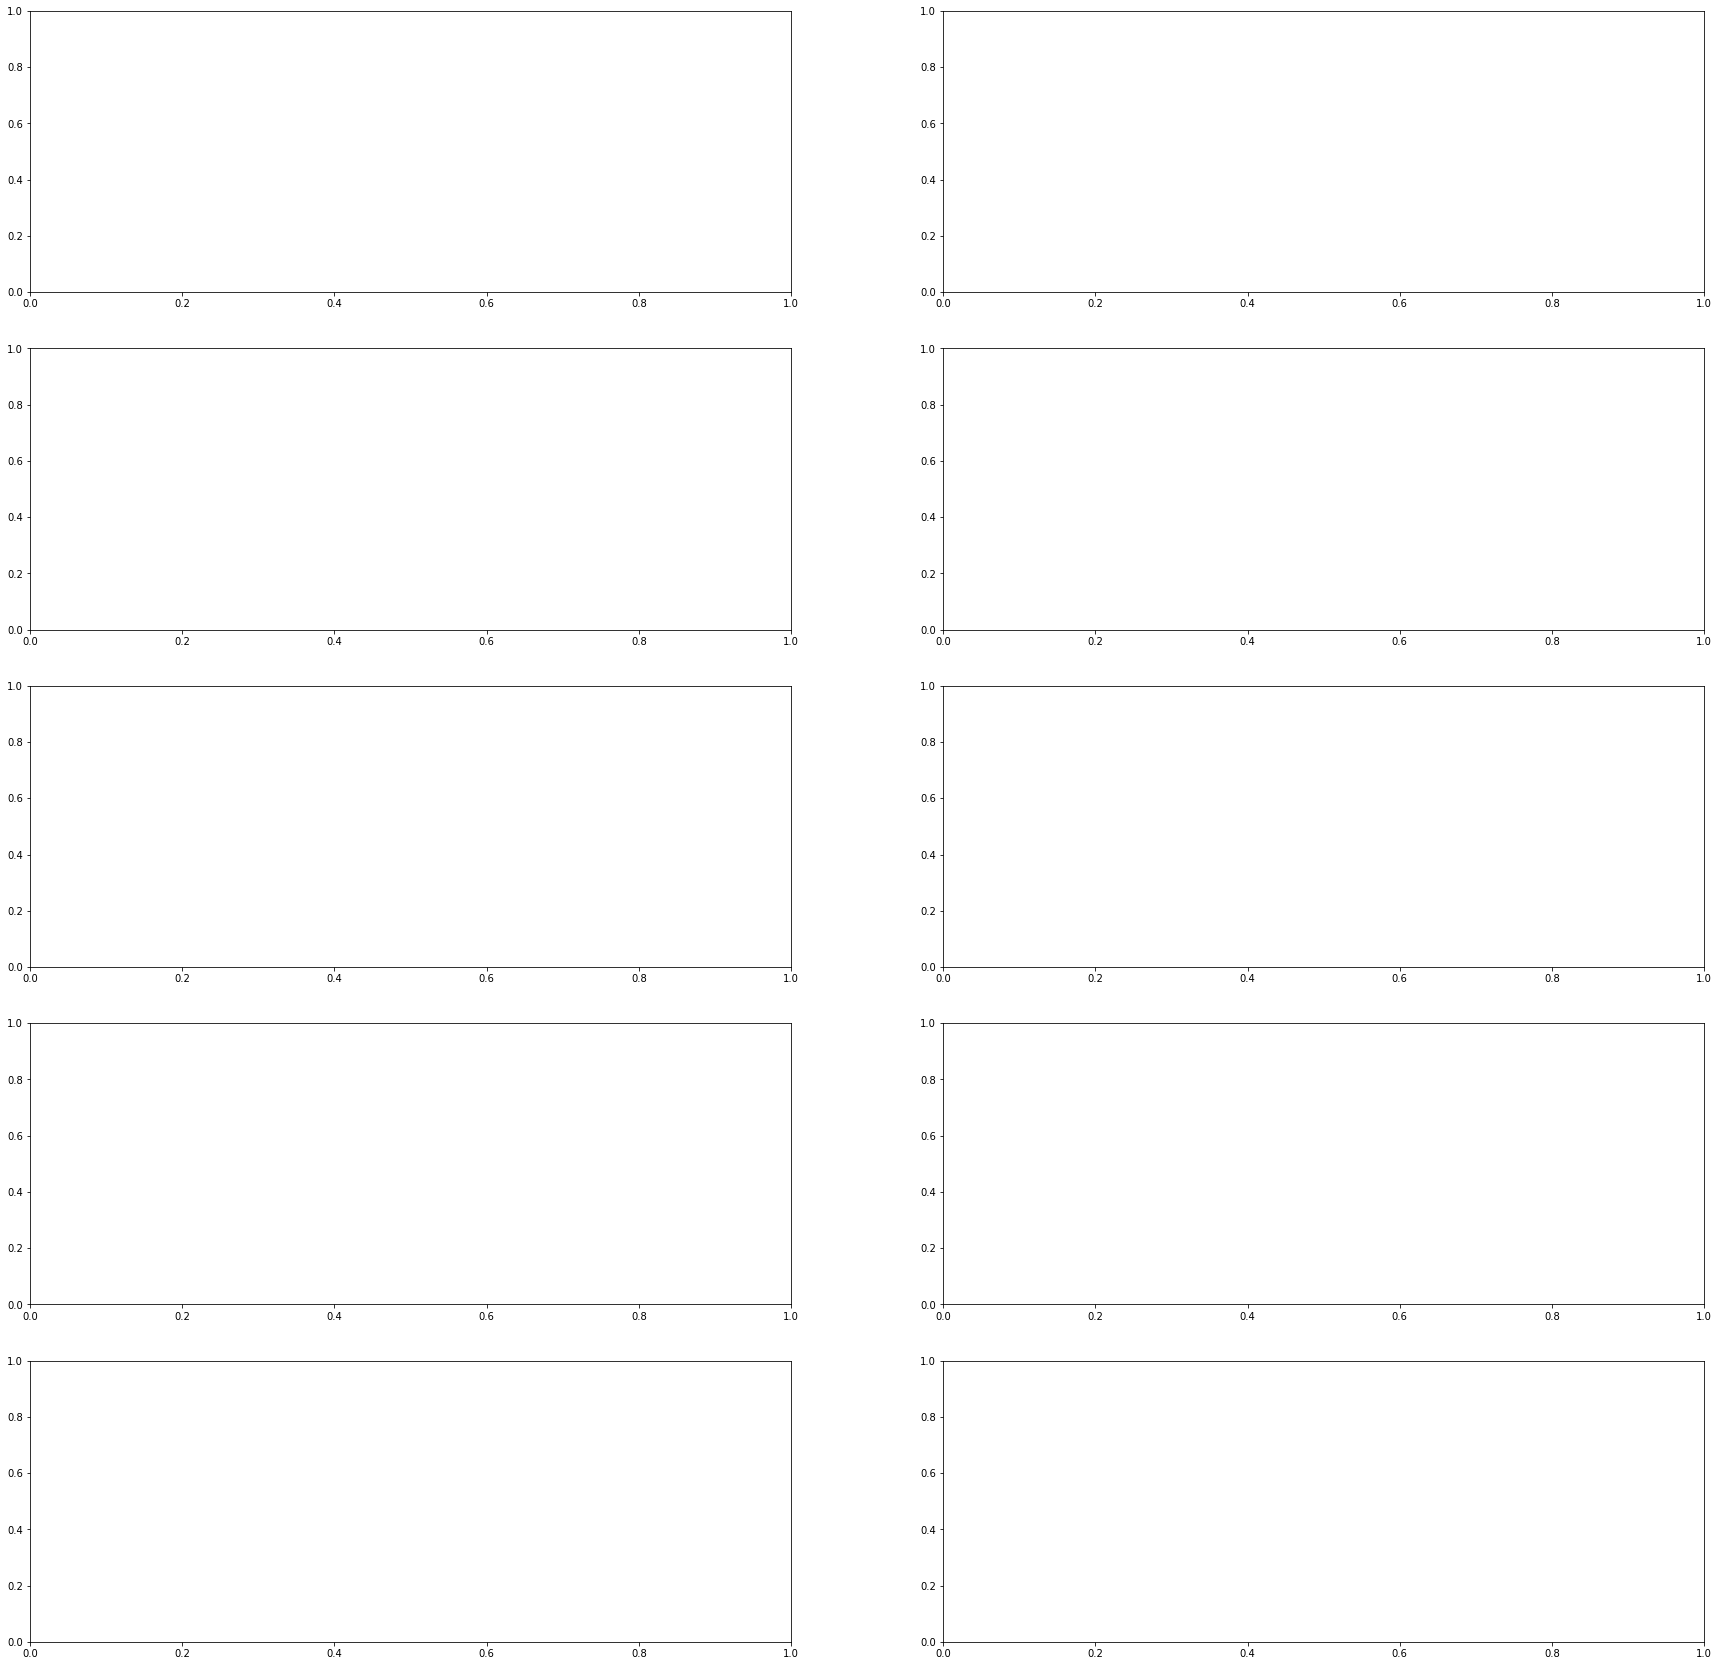

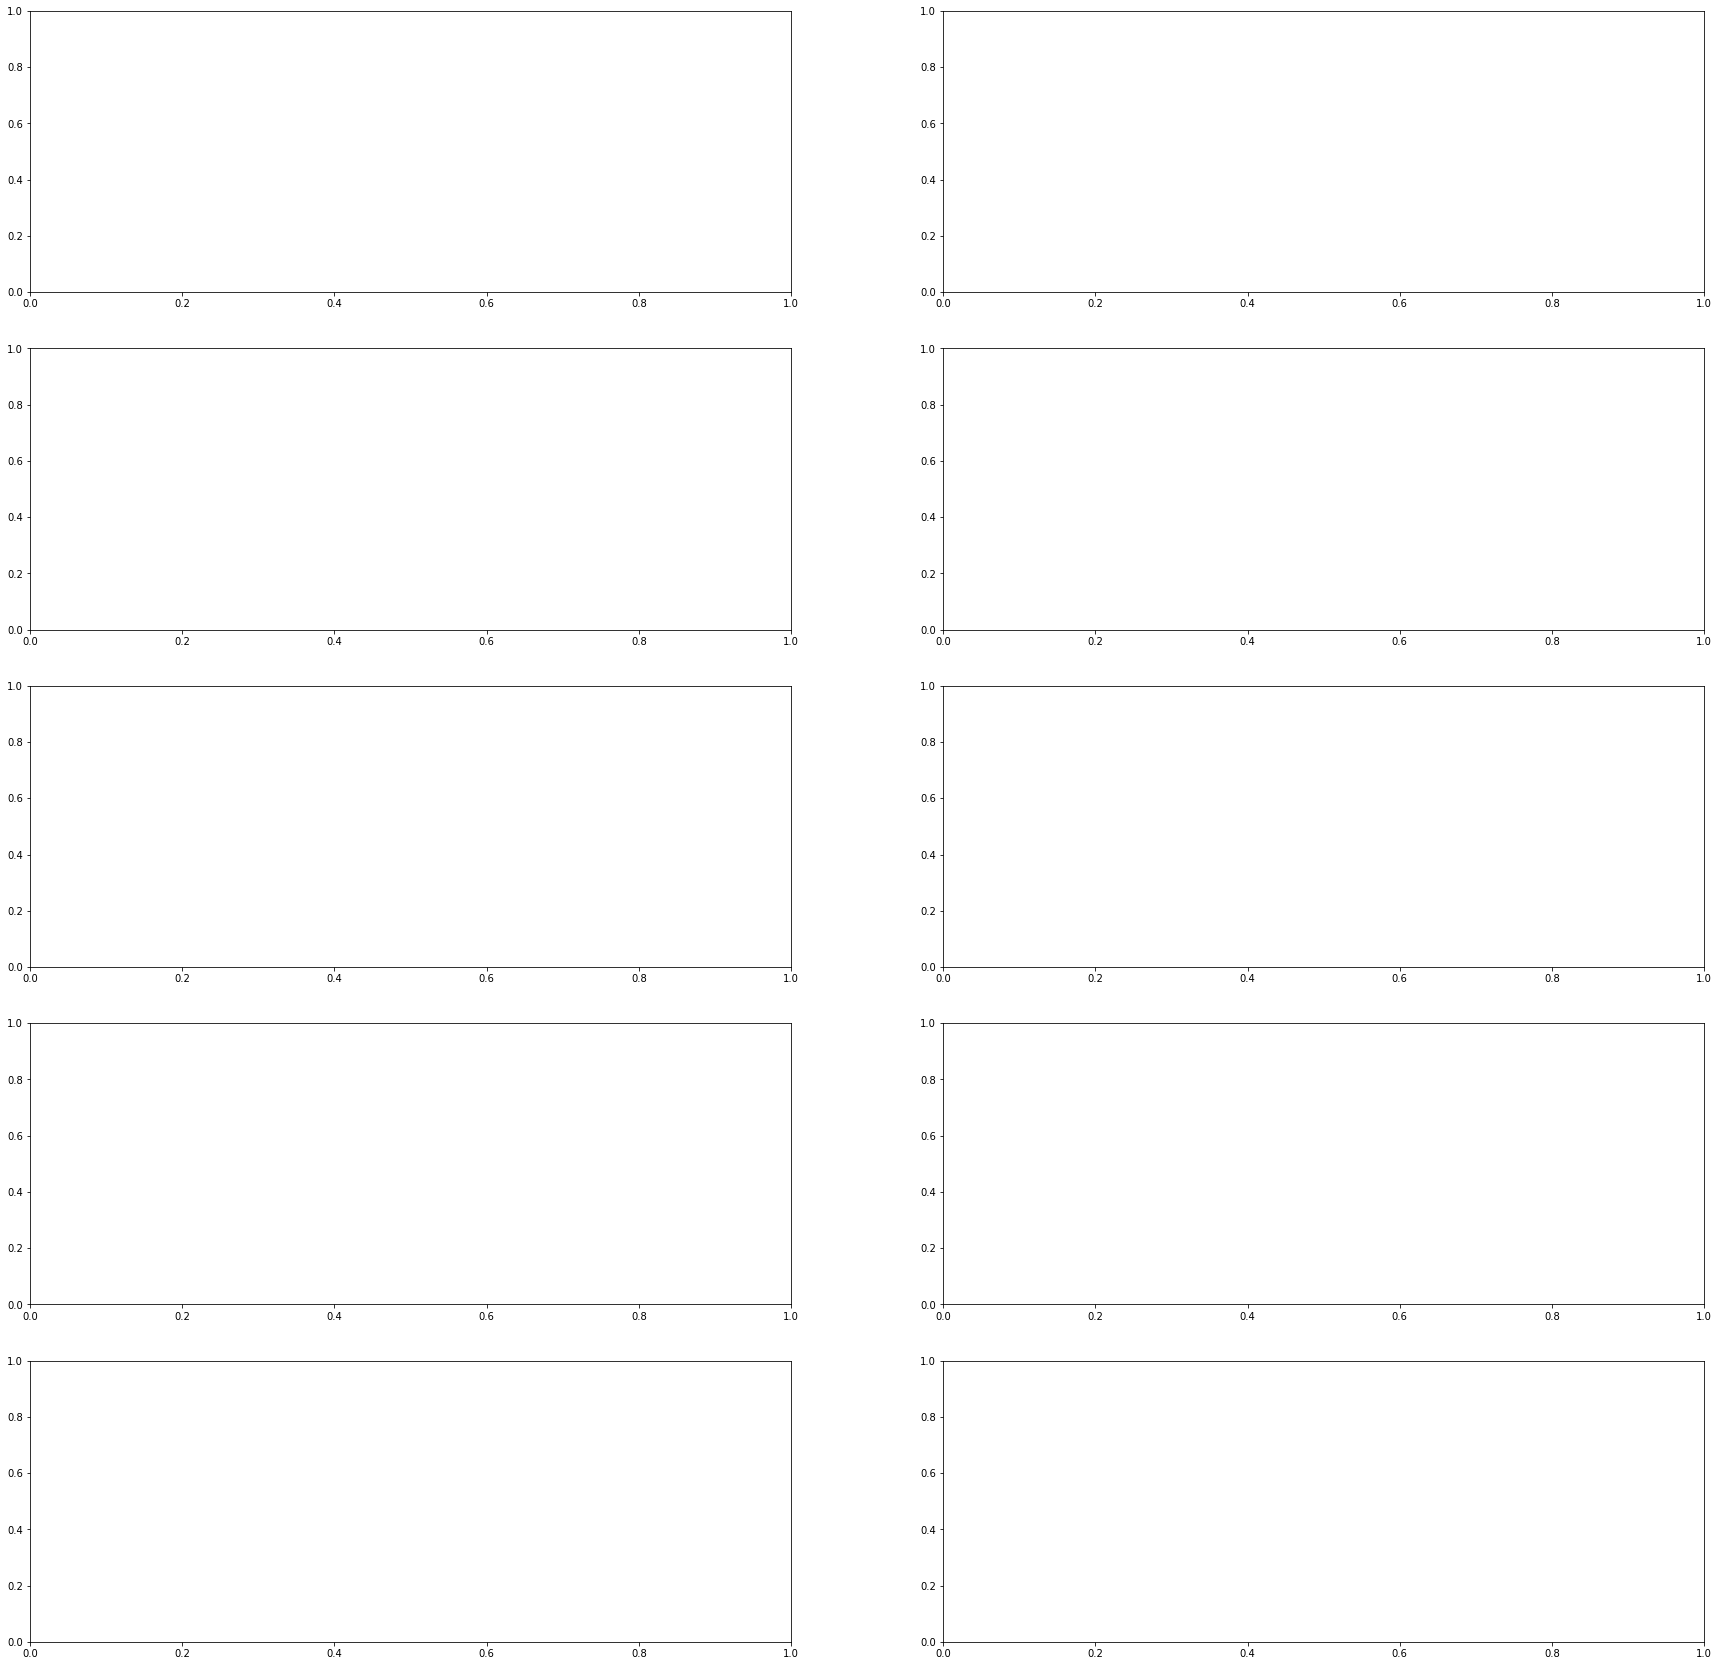

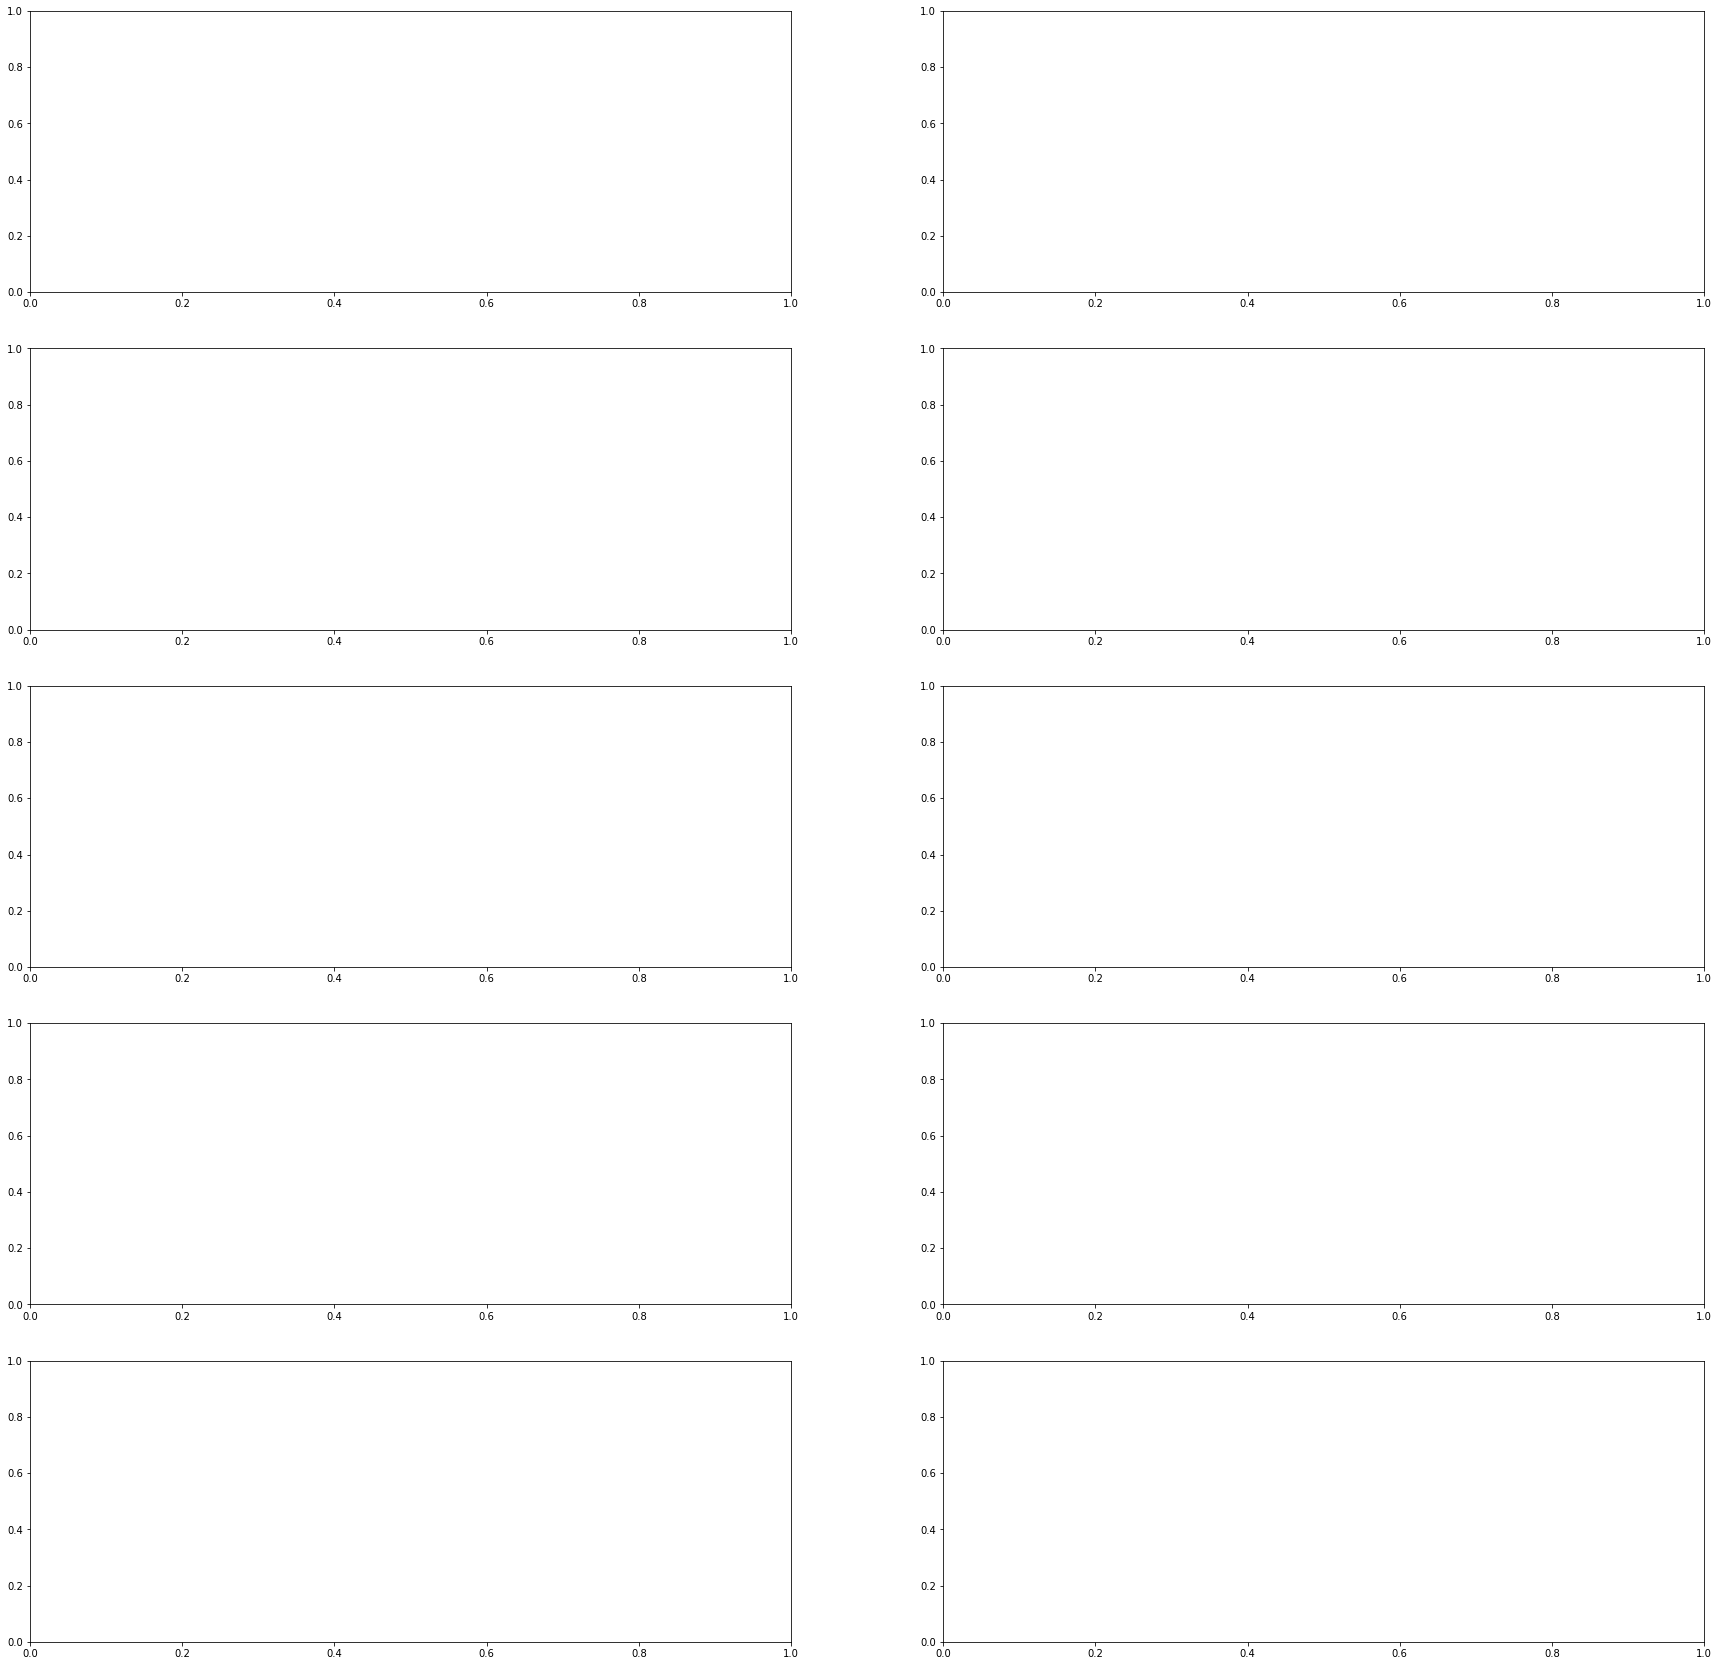

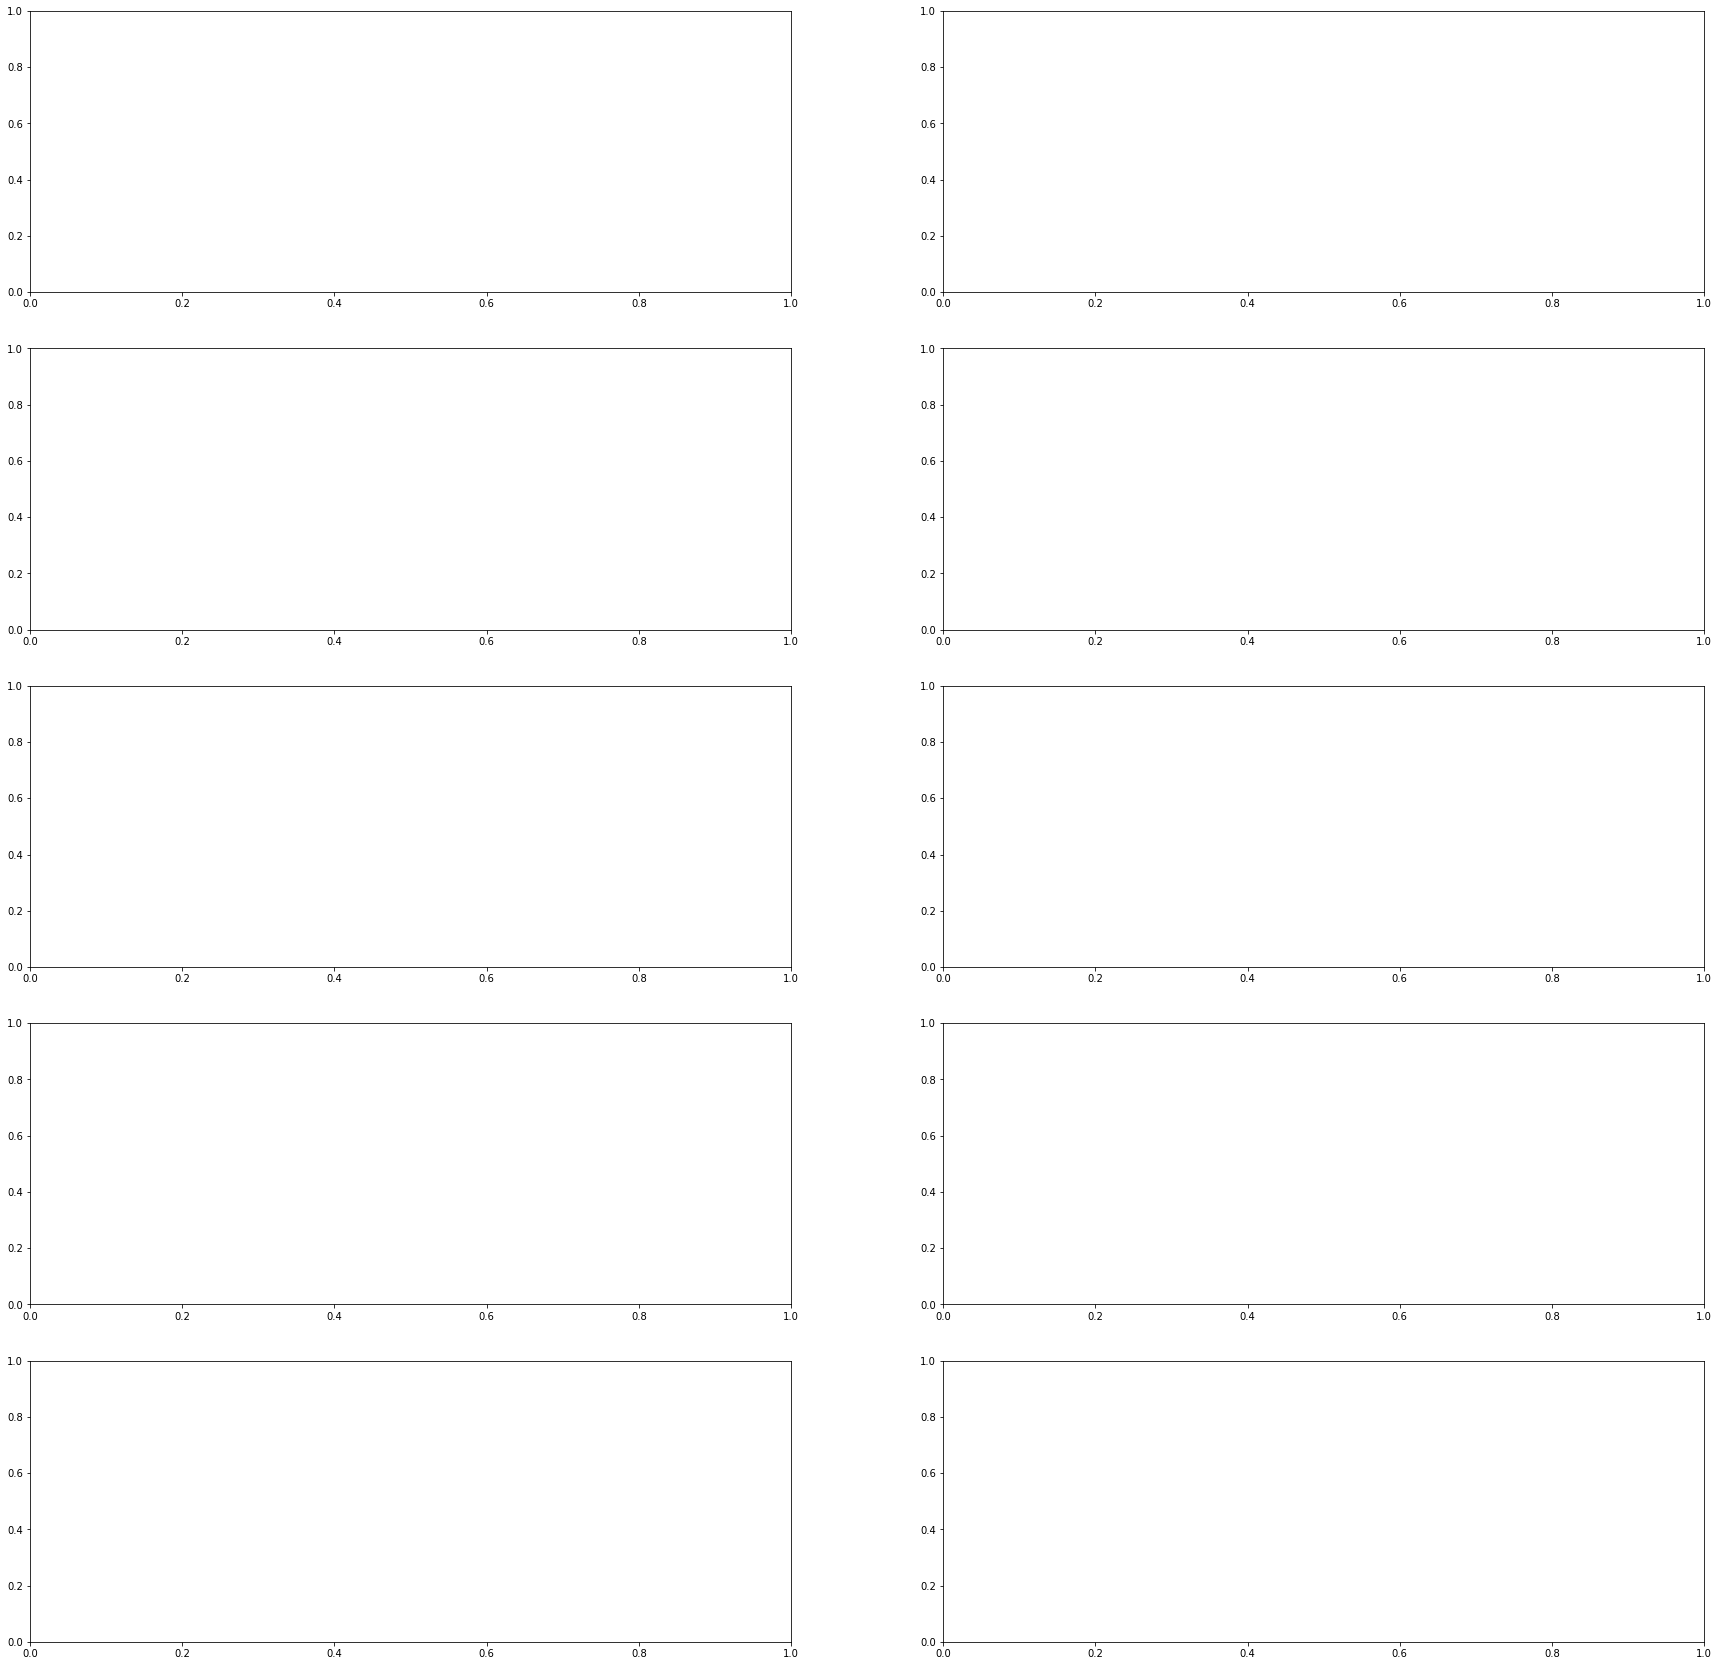

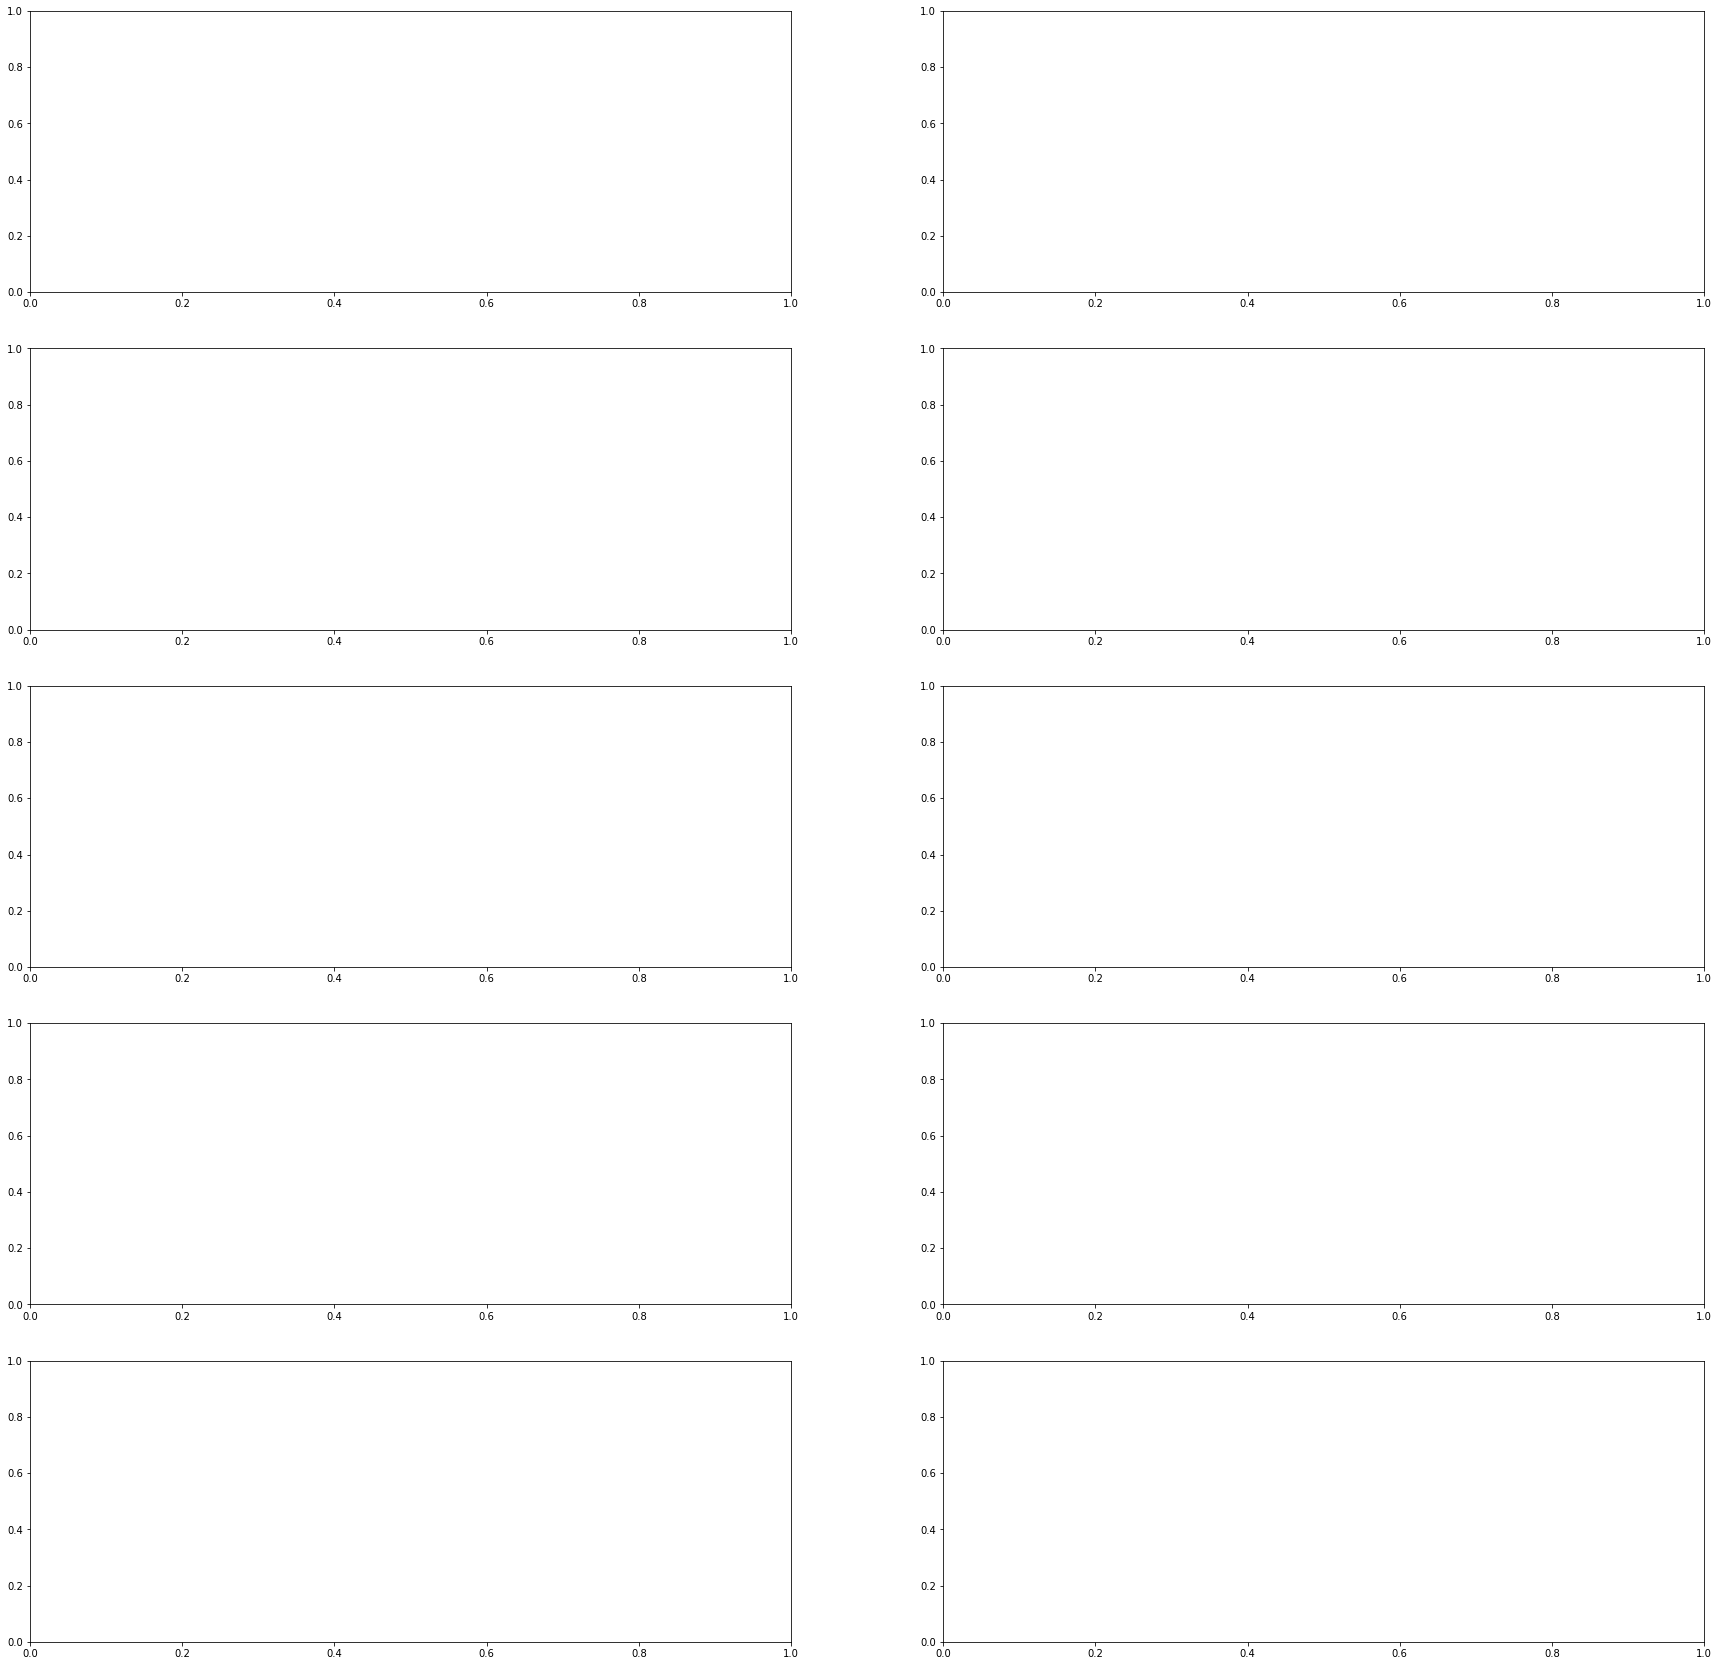

In [42]:
qb10_p_list = [] ##
for k in range(10): #10回回して平均、分散を得る
    y = Array.create('y', shape=num_samples, vartype='BINARY')

    #QUBO式で定式化
    H = (sum(y) - y_sum)**2
    qb = H.compile().to_qubo()
    sa_sampler = SimulatedAnnealingSampler()
    res = sa_sampler.sample_qubo(qb[0], num_reads=numreads_10[3]) #0, 1, 2, 3
    #res = sa_sampler.sample_qubo(qb[0], num_reads=numreads_5[4]) #0, 1, 2, 3, 4
    
    fig, ax = plt.subplots(int(num_cols/2), 2, figsize=(30,30))

    qb_minP_cols = []
    servey_num_col_list = columns
    qb10_p = {} ##
    
    for i in servey_num_col_list: #A, B, ..., 
        ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp

        ti_dic = {} #{内積の値:該当数}という辞書。

        for y_info in list(res.record):
            y = pd.Series(y_info[0])

            if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
                ti_dic[int(np.dot(X_mushroom[i], y))] += 1
            else:
                ti_dic[int(np.dot(X_mushroom[i], y))] = 1

        ti_list = sorted(ti_dic.items()) #listになり、要素はタプルになる。
        franc = sum([j[1] for j in ti_list if j[0] >= ori_ti])
        qb10_p[i] = franc/numreads_10[3] ##
        #qb10_p[i] = franc/numreads_5[4] ##
    
    ##一周終了
    qb10_p_list.append(qb10_p) ##

## 10回終了
to_qubo10_p_10times = pd.DataFrame(qb10_p_list)
print(to_qubo10_p_10times)

#to_qubo10_p_10times.to_csv('../output/to_qubo10_10samples_p_10time.csv')
#to_qubo10_p_10times.to_csv('../output/to_qubo10_100samples_p_10time.csv')
#to_qubo10_p_10times.to_csv('../output/to_qubo10_1000samples_p_10time.csv')
to_qubo10_p_10times.to_csv('../output/to_qubo10_10000samples_p_10time.csv')


##to_qubo10_p_10times.to_csv('../output/to_qubo10_100samples_p_10time.csv')
#to_qubo10_p_10times.to_csv('../output/to_qubo10_500samples_p_10time.csv')
##to_qubo10_p_10times.to_csv('../output/to_qubo10_1000samples_p_10time.csv')
#to_qubo10_p_10times.to_csv('../output/to_qubo10_1500samples_p_10time.csv')
#to_qubo10_p_10times.to_csv('../output/to_qubo10_2000samples_p_10time.csv')

In [ ]:
#num_reads=100
#num_reads=200
#num_reads=210
#num_reads=300
#num_reads=400
#num_reads=500
#num_reads=600
#num_reads=700
#num_reads=800
#num_reads=900

In [261]:
y = Array.create('y', shape=num_samples, vartype='BINARY')

#QUBO式で定式化
H = (sum(y) - y_sum)**2
qb = H.compile().to_qubo()
sa_sampler = SimulatedAnnealingSampler()

res = sa_sampler.sample_qubo(qb[0], num_reads=num_reads)

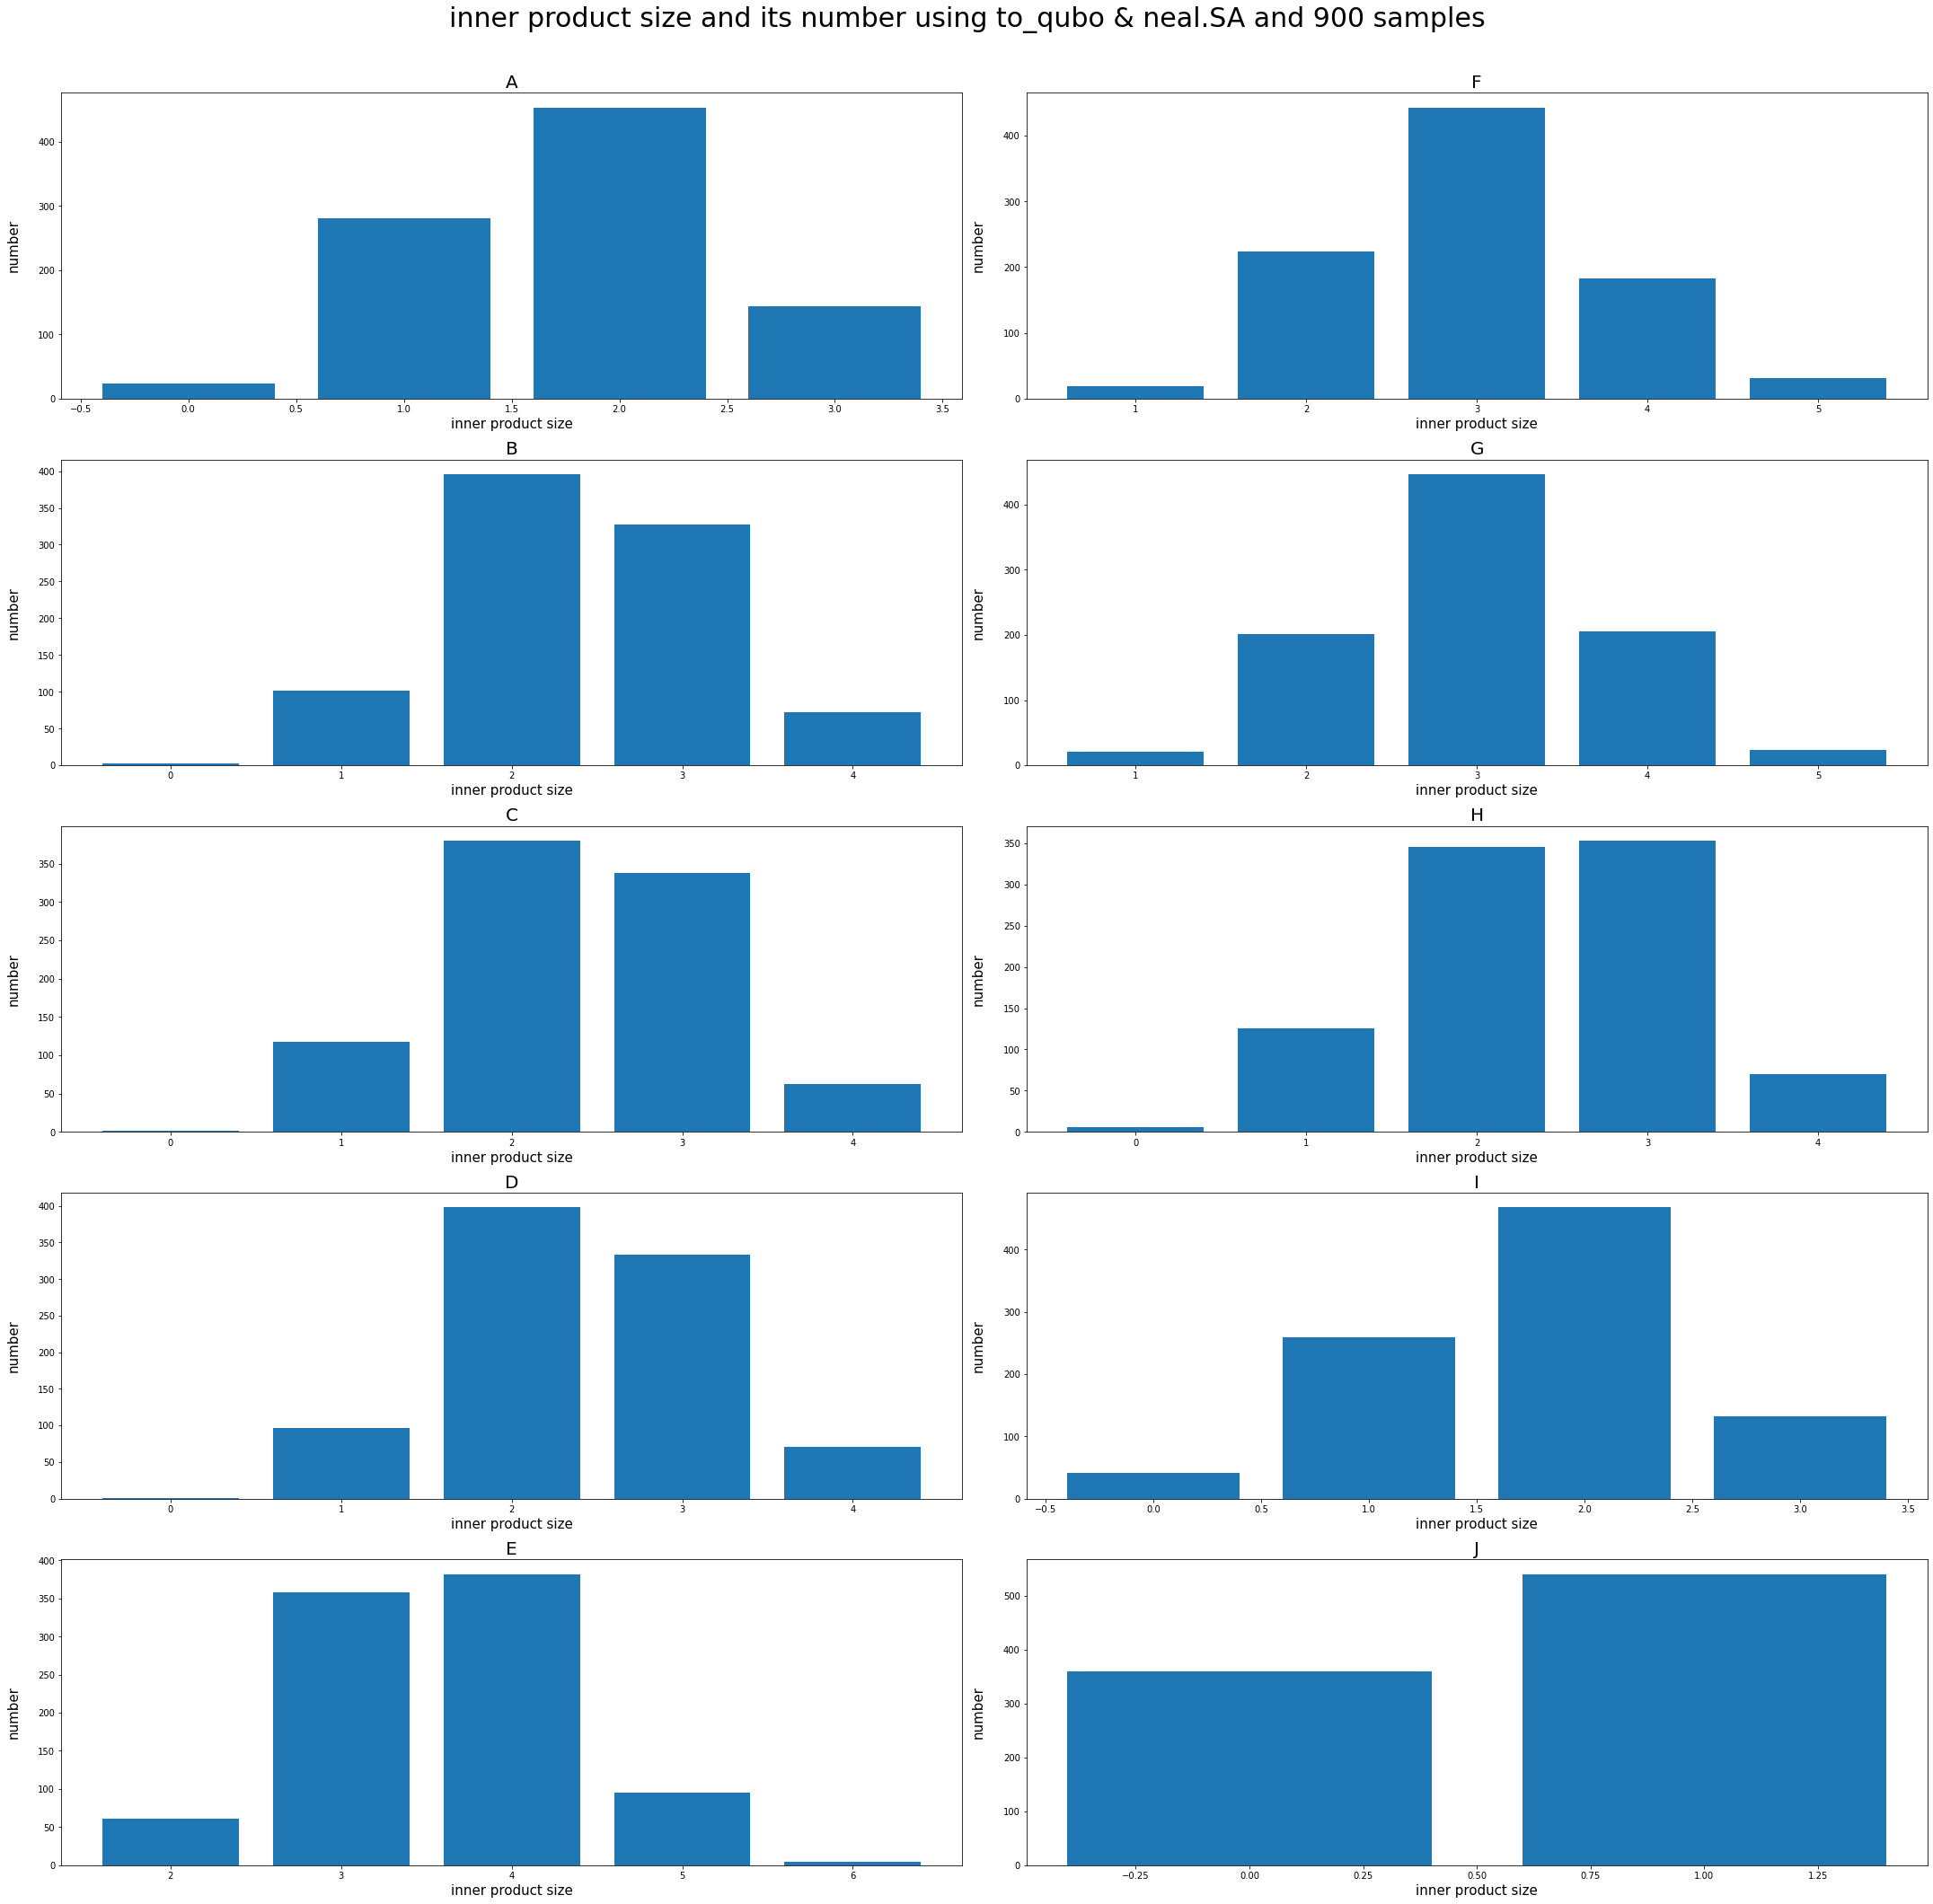

          A         B         C         D         E     F         G         H  \
0  0.158889  0.884444  0.445556  0.448889  0.534444  0.73  0.752222  0.993333   

          I    J  
0  0.954444  1.0  


In [262]:
fig, ax = plt.subplots(int(num_cols/2), 2, figsize=(30,30))

qb_minP_cols = []
servey_num_col_list = columns
qb10_p = {}
for index, i in enumerate(servey_num_col_list):
    ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp

    ti_dic = {} #{内積の値:該当数}という辞書。

    for y_info in list(res.record):
        y = pd.Series(y_info[0])

        if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
            ti_dic[int(np.dot(X_mushroom[i], y))] += 1
        else:
            ti_dic[int(np.dot(X_mushroom[i], y))] = 1

    ti_list = sorted(ti_dic.items()) #listになり、要素はタプルになる。
    franc = sum([j[1] for j in ti_list if j[0] >= ori_ti])
    qb10_p[i] = franc/num_reads
    
    n_row = int(index%int(num_cols/2))
    
    if index < int(num_cols/2):
        n_col = 0
    else:
        n_col = 1
    
    # ヒストグラムを出力
    ax[n_row, n_col].set_title(i, fontsize=20)
    ax[n_row, n_col].bar([j[0] for j in ti_list], [j[1] for j in ti_list])
    ax[n_row, n_col].scatter(ori_ti, 100, s=200, marker='D')
    ax[n_row, n_col].set_xlabel('inner product size', fontsize=15)
    ax[n_row, n_col].set_ylabel('number', rotation=90, fontsize=15, labelpad=20)
    
#図が重ならないようにする
fig.tight_layout(rect=[0,0,1,0.95])
    
#全体に一つの題名を表示
#fig.suptitle('inner product size and its number using to_qubo & neal.SA and 100 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_qubo & neal.SA and 200 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_qubo & neal.SA and 210 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_qubo & neal.SA and 300 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_qubo & neal.SA and 400 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_qubo & neal.SA and 500 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_qubo & neal.SA and 600 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_qubo & neal.SA and 700 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_qubo & neal.SA and 800 samples', fontsize=30)
fig.suptitle('inner product size and its number using to_qubo & neal.SA and 900 samples', fontsize=30)

#図を表示
plt.show()

#fig.savefig('../output/to_qubo10_100samples_inner_product.png')
#fig.savefig('../output/to_qubo10_200samples_inner_product.png')
#fig.savefig('../output/to_qubo10_210samples_inner_product.png')
#fig.savefig('../output/to_qubo10_300samples_inner_product.png')
#fig.savefig('../output/to_qubo10_400samples_inner_product.png')
#fig.savefig('../output/to_qubo10_500samples_inner_product.png')
#fig.savefig('../output/to_qubo10_600samples_inner_product.png')
#fig.savefig('../output/to_qubo10_700samples_inner_product.png')
#fig.savefig('../output/to_qubo10_800samples_inner_product.png')
fig.savefig('../output/to_qubo10_900samples_inner_product.png')

to_qubo10_p = pd.DataFrame.from_dict(qb10_p, orient='index').T
print(to_qubo10_p)

#to_qubo10_p.to_csv('../output/to_qubo10_100samples_p.csv')
#to_qubo10_p.to_csv('../output/to_qubo10_200samples_p.csv')
#to_qubo10_p.to_csv('../output/to_qubo10_210samples_p.csv')
#to_qubo10_p.to_csv('../output/to_qubo10_300samples_p.csv')
#to_qubo10_p.to_csv('../output/to_qubo10_400samples_p.csv')
#to_qubo10_p.to_csv('../output/to_qubo10_500samples_p.csv')
#to_qubo10_p.to_csv('../output/to_qubo10_600samples_p.csv')
#to_qubo10_p.to_csv('../output/to_qubo10_700samples_p.csv')
#to_qubo10_p.to_csv('../output/to_qubo10_800samples_p.csv')
to_qubo10_p.to_csv('../output/to_qubo10_900samples_p.csv')

#### to_dimod_bqmでのトライアル（t^0だけ）

In [266]:
#num_reads=100
#num_reads=200
#num_reads=210
#num_reads=300
#num_reads=400
#num_reads=500
#num_reads=600
#num_reads=700
#num_reads=800
num_reads=900

In [269]:
y = Array.create('y', shape=num_samples, vartype='BINARY')

#QUBO式で定式化
H = (sum(y) - y_sum)**2
bqm = H.compile().to_dimod_bqm()
sa_sampler = SimulatedAnnealingSampler()

res = sa_sampler.sample(bqm, num_reads=num_reads)
#res

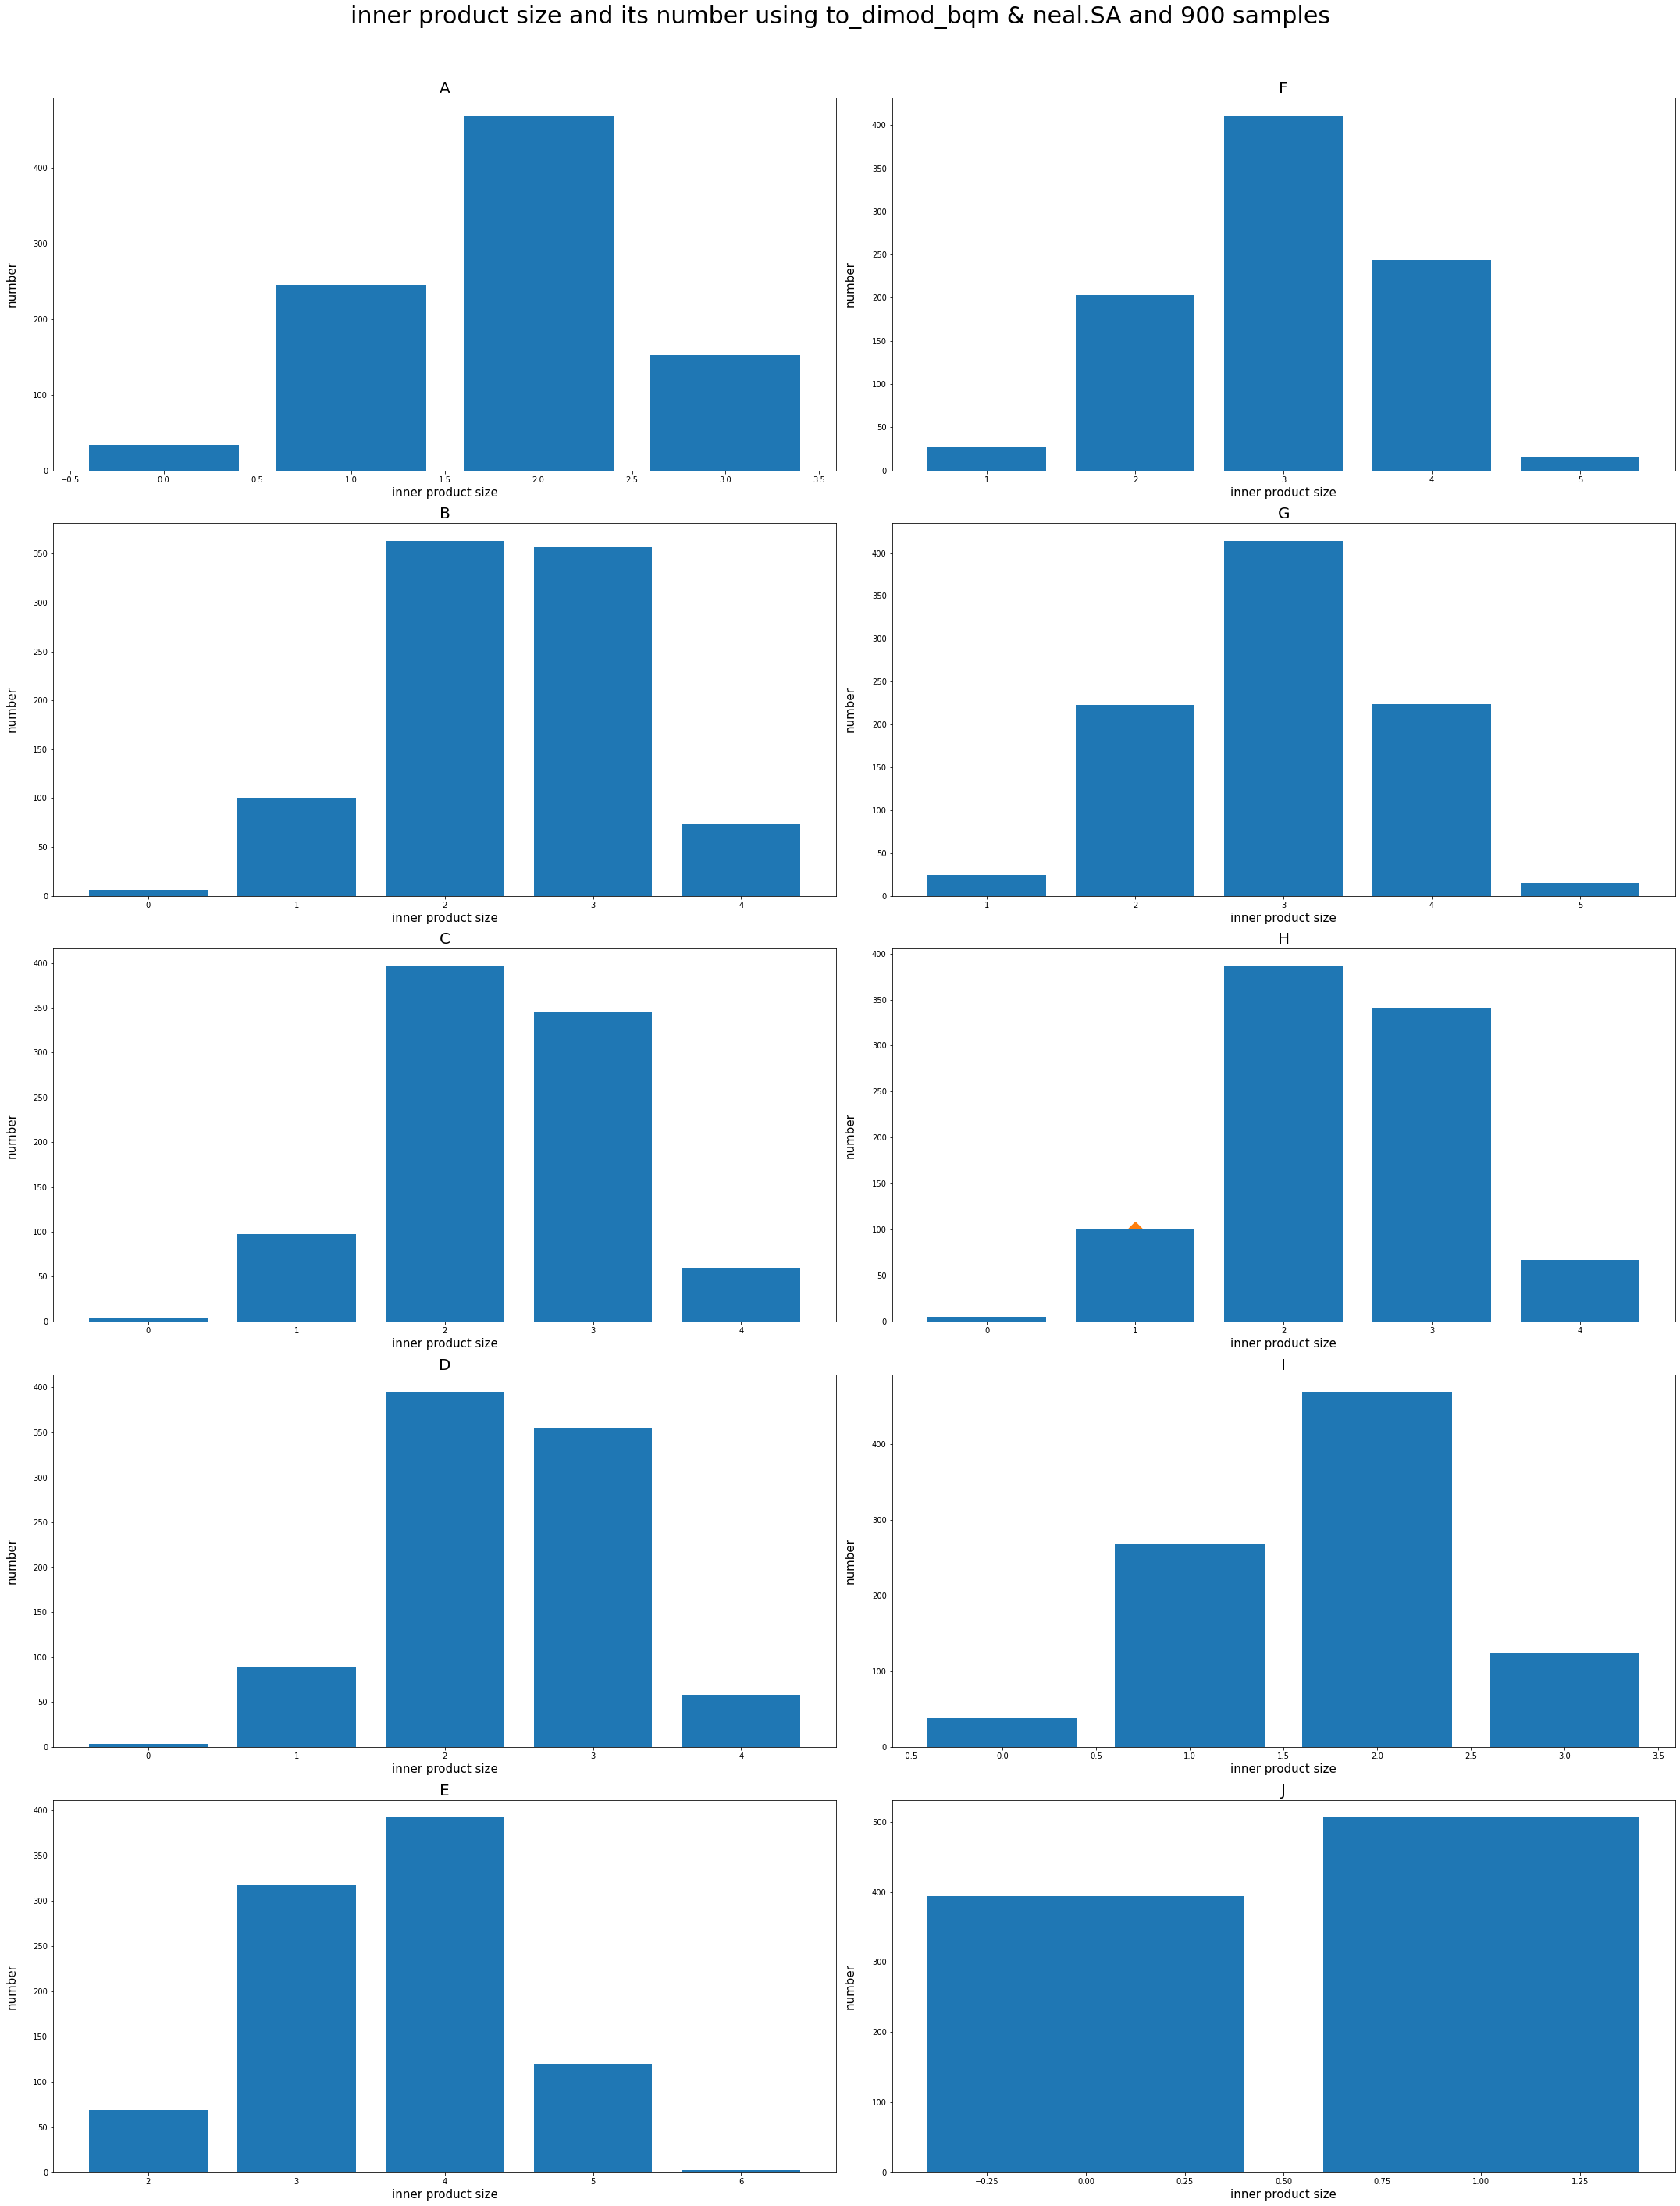

          A         B         C         D         E         F         G  \
0  0.168889  0.882222  0.448889  0.458889  0.571111  0.744444  0.725556   

          H         I    J  
0  0.994444  0.957778  1.0  


In [265]:
fig, ax = plt.subplots(int(num_cols/2), 2, figsize=(30,40))

bqm_minP_cols = []
servey_num_col_list = columns
bqm10_p = {}
for index, i in enumerate(servey_num_col_list):
    ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp

    ti_dic = {} #{内積の値:該当数}という辞書。

    for y_info in list(res.record):
        y = pd.Series(y_info[0])

        if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
            ti_dic[int(np.dot(X_mushroom[i], y))] += 1
        else:
            ti_dic[int(np.dot(X_mushroom[i], y))] = 1

    ti_list = sorted(ti_dic.items()) #listになり、要素はタプルになる。
    franc = sum([j[1] for j in ti_list if j[0] >= ori_ti])
    bqm10_p[i] = franc/num_reads
    
    n_row = int(index%int(num_cols/2))
    
    if index < int(num_cols/2):
        n_col = 0
    else:
        n_col = 1
    
    # ヒストグラムを出力
    ax[n_row, n_col].set_title(i, fontsize=20)
    ax[n_row, n_col].bar([j[0] for j in ti_list], [j[1] for j in ti_list])
    ax[n_row, n_col].scatter(ori_ti, 100, s=200, marker='D')
    ax[n_row, n_col].set_xlabel('inner product size', fontsize=15)
    ax[n_row, n_col].set_ylabel('number', rotation=90, fontsize=15, labelpad=20)
    
#図が重ならないようにする
fig.tight_layout(rect=[0,0,1,0.95])
    
#全体に一つの題名を表示
#fig.suptitle('inner product size and its number using to_dimod_bqm & neal.SA and 100 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_dimod_bqm & neal.SA and 200 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_dimod_bqm & neal.SA and 210 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_dimod_bqm & neal.SA and 300 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_dimod_bqm & neal.SA and 400 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_dimod_bqm & neal.SA and 500 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_dimod_bqm & neal.SA and 600 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_dimod_bqm & neal.SA and 700 samples', fontsize=30)
#fig.suptitle('inner product size and its number using to_dimod_bqm & neal.SA and 800 samples', fontsize=30)
fig.suptitle('inner product size and its number using to_dimod_bqm & neal.SA and 900 samples', fontsize=30)


#図を表示
plt.show()

#fig.savefig('../output/to_bqm10_100samples_inner_product.png')
#fig.savefig('../output/to_bqm10_200samples_inner_product.png')
#fig.savefig('../output/to_bqm10_210samples_inner_product.png')
#fig.savefig('../output/to_bqm10_300samples_inner_product.png')
#fig.savefig('../output/to_bqm10_400samples_inner_product.png')
#fig.savefig('../output/to_bqm10_500samples_inner_product.png')
#fig.savefig('../output/to_bqm10_600samples_inner_product.png')
#fig.savefig('../output/to_bqm10_700samples_inner_product.png')
#fig.savefig('../output/to_bqm10_800samples_inner_product.png')
fig.savefig('../output/to_bqm10_900samples_inner_product.png')


to_bqm10_p = pd.DataFrame.from_dict(bqm10_p, orient='index').T
print(to_bqm10_p)

#to_bqm10_p.to_csv('../output/to_bqm10_100samples_p.csv')
#to_bqm10_p.to_csv('../output/to_bqm10_200samples_p.csv')
#to_bqm10_p.to_csv('../output/to_bqm10_210samples_p.csv')
#to_bqm10_p.to_csv('../output/to_bqm10_300samples_p.csv')
#to_bqm10_p.to_csv('../output/to_bqm10_400samples_p.csv')
#to_bqm10_p.to_csv('../output/to_bqm10_500samples_p.csv')
#to_bqm10_p.to_csv('../output/to_bqm10_600samples_p.csv')
#to_bqm10_p.to_csv('../output/to_bqm10_700samples_p.csv')
#to_bqm10_p.to_csv('../output/to_bqm10_800samples_p.csv')
to_bqm10_p.to_csv('../output/to_bqm10_900samples_p.csv')

In [ ]:
'''
bqm_minP_cols = []
servey_num_col_list = columns

bqm10_p = {}
for i in servey_num_col_list:
    ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp

    ti_dic = {} #{内積の値:該当数}という辞書。

    for y_info in list(res.record):
        y = pd.Series(y_info[0])

        if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
            ti_dic[int(np.dot(X_mushroom[i], y))] += 1
        else:
            ti_dic[int(np.dot(X_mushroom[i], y))] = 1

    ti_list = sorted(ti_dic.items()) #listになり、要素はタプルになる。
    franc = sum([j[1] for j in ti_list if j[0] >= ori_ti])
    bqm10_p[i] = franc/num_reads
    
    # ヒストグラムを出力
    plt.figure(figsize=(5, 5))
    plt.title(i) 
    plt.bar([j[0] for j in ti_list], [j[1] for j in ti_list])
    plt.xlabel('inner product size', fontsize=15)
    plt.ylabel('number', rotation=90, fontsize=15, labelpad=20)
    plt.scatter(ori_ti, 100, s=200, marker='D')

#図が重ならないようにする
plt.tight_layout()

#全体に一つの題名を表示
fig.suptitle('inner product size and its size using to_dimod_bqm & neal.SA', fontsize=20)


#図を表示
plt.show()

to_bqm10_p = pd.DataFrame.from_dict(bqm10_p, orient='index').T
print(to_bqm10_p)

#to_bqm10_p.to_csv('../input/to_bqm10_100samples_p.csv')
#to_bqm10_p.to_csv('../input/to_bqm10_200samples_p.csv')
#to_bqm10_p.to_csv('../input/to_bqm10_210samples_p.csv')
#to_bqm10_p.to_csv('../input/to_bqm10_300samples_p.csv')
#to_bqm10_p.to_csv('../input/to_bqm10_400samples_p.csv')
#to_bqm10_p.to_csv('../input/to_bqm10_500samples_p.csv')
#to_bqm10_p.to_csv('../input/to_bqm10_600samples_p.csv')
'''

### 全体

In [80]:
def SA_qb_y(minP_cols):
    # BINARY変数
    y = Array.create('y', shape=num_samples, vartype='BINARY')

    #QUBO式で定式化
    H = (sum(y) - y_sum)**2

    if len(minP_cols) > 0:
        for i in minP_cols:
            H_plus = (np.dot(X_mushroom[i], y) - np.dot(X_mushroom[i], y_mushroom))**2
            H = H + H_plus

    qb = H.compile().to_qubo()

    sa_sampler = SimulatedAnnealingSampler()

    res = sa_sampler.sample_qubo(qb[0], num_reads=100)
    
    return list(res.record)

In [81]:
def SA_bqm_y(minP_cols):
    # BINARY変数
    y = Array.create('y', shape=num_samples, vartype='BINARY')
    
    #QUBO式で定式化
    H = (sum(y) - y_sum)**2
    
    if len(minP_cols) > 0:
        for i in minP_cols:
            H_plus = (np.dot(X_mushroom[i], y) - np.dot(X_mushroom[i], y_mushroom))**2
            H = H + H_plus
    
    bqm = H.compile().to_dimod_bqm()

    sa_sampler = SimulatedAnnealingSampler()
    
    res = sa_sampler.sample(bqm, num_reads=100)

    return list(res.record)

In [73]:
bqm_minP_cols = []
servey_num_col_list = columns
distri_element_num = 100

while len(servey_num_col_list) > 0:    
    p = {}
    for i in servey_num_col_list:
        ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp
        
        ti_dic = {} #{内積の値:該当数}という辞書。
        
        res_record = SA_bqm_y(minP_cols)
        for y_info in res_record:
            y = pd.Series(y_info[0])
            
            if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
                ti_dic[int(np.dot(X_mushroom[i], y))] += 1
            else:
                ti_dic[int(np.dot(X_mushroom[i], y))] = 1
                
        count_better_t = sum([v for k, v in ti_dic.items() if k >= ori_ti])
        p[i] = count_better_t / distri_element_num

        
    bqm_minP_keys = [k for k, v in p.items() if v == min(list(p.values()))]
    print(bqm_minP_keys)
    bqm_minP_cols += bqm_minP_keys
    servey_num_col_list = [i for i in servey_num_col_list if i not in bqm_minP_keys]

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


In [74]:
bqm_minP_cols #['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [82]:
qb_minP_cols = []
servey_num_col_list = columns
distri_element_num = 100

while len(servey_num_col_list) > 0:    
    p = {}
    for i in servey_num_col_list:
        ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp
        
        ti_dic = {} #{内積の値:該当数}という辞書。
        
        res_record = SA_qb_y(minP_cols)
        for y_info in res_record:
            y = pd.Series(y_info[0])
            
            if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
                ti_dic[int(np.dot(X_mushroom[i], y))] += 1
            else:
                ti_dic[int(np.dot(X_mushroom[i], y))] = 1
                
        count_better_t = sum([v for k, v in ti_dic.items() if k >= ori_ti])
        p[i] = count_better_t / distri_element_num

        
    qb_minP_keys = [k for k, v in p.items() if v == min(list(p.values()))]
    print(bqm_minP_keys)
    qb_minP_cols += qb_minP_keys
    servey_num_col_list = [i for i in servey_num_col_list if i not in qb_minP_keys]

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


In [83]:
qb_minP_cols #['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [ ]:
'''
minP_cols = []
servey_num_col_list = columns

while len(servey_num_col_list) > 0:    
    p = {}
    for i in servey_num_col_list:
        ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp
        
        ti_dic = {} #分布の要素となる値を格納する
        for _ in range(100): 
            y = make_y(minP_cols)
            
            if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
                ti_dic[int(np.dot(X_mushroom[i], y))] += 1
            else:
                ti_dic[int(np.dot(X_mushroom[i], y))] = 1
                
        bunshi = sum([ti_dic[ii] for ii in range(ori_ti, int(list(ti_dic.keys())[-1])+1)])
        p[i] = bunshi/sum(list(ti_dic.values()))
        
    minP_keys = [k for k, v in p.items() if v == min(list(p.values()))]
    minP_cols += minP_keys
    servey_num_col_list = [i for i in servey_num_col_list if i not in minP_keys]
    
#minP_cols #['A', 'D', 'G', 'I', 'C', 'F', 'E', 'B', 'H', 'J']
'''

In [ ]:
'''
if not ori_ti in ti_dic.keys():
    ti_dic[ori_ti] = 1                        
ti_list = sorted(ti_dic.items()) #listになり、要素はタプルになる。
franc = sum([j[1] for j in ti_list if j[0] >= ori_ti])
denomi = sum([j[1] for j in ti_list])
p[i] = franc/denomi

↓

count_better_t = sum([v for k, v in ti_dic.items() if k >= ori_ti])
p[i] = count_better_t / distri_element_num


結果
#minP_cols #['A', 'D', 'F', 'I', 'E', 'G', 'C', 'B', 'H', 'J']
'''

In [ ]:
'''
def make_y(minP_cols):
    # BINARY変数
    y = Array.create('y', shape=num_samples, vartype='BINARY')
    
    #QUBO式で定式化
    H = (sum(y) - y_sum)**2
    
    if len(minP_cols) > 0:
        for i in minP_cols:
            H_plus = (np.dot(X_mushroom[i], y) - np.dot(X_mushroom[i], y_mushroom))**2
            H = H + H_plus
    
    bqm = H.compile().to_dimod_bqm()

    sa_sampler = SimulatedAnnealingSampler()
    
    res = sa_sampler.sample(bqm, num_reads=100)

    return list(res.record)
    
結果
#minP_cols #['A', 'D', 'F', 'I', 'E', 'G', 'C', 'B', 'H', 'J']
'''